<b>Student Name:</b> Shubham Sarjerao Chaudhari<br>
<b>Student ID:</b> x20160836<br>
<b>Student Email ID:</b> x20160836@student.ncirl.ie <br>
<b>Subject:</b>Modelling, Simulation and Optimisation<br>
<b>Lecturer:</b>Prof. Christian Horn<br>
<b>College:</b> National College of Ireland

<h1><center>Modelling, Simulation and Optimisation</center></h1>
<h1><center>CA-1</center></h1>

![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQvNuFdW-fiW0QWq3OuSRJF8Lqb9Z0VMiHbGA&usqp=CAU)

### Project Outline

The “Future Cities” Project in Trinity College Dublin investigates a “Self-Organising 
Motorway” as a possible approach to reduce congestion on motorways. Your task is to 
replicate aspects of this research using a simulation model implemented in SimPy v.4.
Create a simulation for a 3km segment of motorway that reduces after 2km from 3 lanes to 
2 lanes, as shown below on a screen shot from the TCD website.

### Simulation
For this simulation study you will have to make a number of assumptions about the vehicle’s 
parameters (vehicle size, average and maximum acceleration and deceleration and possible 
automation) and the driver’s behaviour (speed variability and rules for acceleration and 
braking, lane change, and yielding to other cars). 
You have free choice about these assumptions, but the assumptions you made need to be 
clearly documented in the final report.
To obtain statistically meaningful results, you may have to run each simulation for a 
minimum number of vehicles. You argue for the number of vehicles you have chosen.

### Requirements
Your task is to investigate for suitable points along the motorway segment\
<b>
• The traffic density k (the number of vehicles per km across all available lanes)\
• The mean speed of the vehicles u and for the overall motorway segment\
• The traffic volume q (i.e. the total number of vehicles passing per hour across all available lanes)\
• The average total travelling time depending on certain input parameter:\
• Motorway speed limits settings (60km/h, 80km/h, 100km/h, and 120km/h)\ 
• Inter-arrival time distributions (directly influencing the traffic density)\
• Traffic mix (percentage of heavy goods vehicles, electrical, autonomous cars)\
</b>
Report the highest traffic volume the motorway segment can accommodate and articulate 
your recommendations regarding the setting of speed limits on the motorway segment.

### Import Libraries

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import numpy as np
import random
import csv
import simpy
import os 

import simpy

### Utilities

In [2]:
def isZero(x, ε = 0.00001):
    return abs(x)<ε
def speedMapping(variation_type):
    if(variation_type == 'LESS'):
        return 0.04
    elif(variation_type == 'MEDIUM'):
        return 0.05
    else:
        return 0.06

Time tolerance: when at current speed difference a crash might occur within that number of seconds

In [3]:
CRITICAL_TIME_TOLERANCE = 4  # [s] 
LANE_CHANGE_TIME = 3 # [s]
MIN_TIME_DIFF = 1

MIN_SPEED_DIFF = 2 # [m/s] min speed diff to trigger overtaking

CAR_LENGTH = random.randint(4,6)  # [m]

FAR_AWAY_IN_FRONT = 200 # [m]  distance at which a car in front can be ignored
FAR_AWAY_IN_BACK = 80   # [m]  distance at which a car behind can be ignored

### Bell Curve Random Generator

In [4]:
gen_x_tab = None
gen_y_tab = None

def pdfv(x, mean=0, sd=None, delta=None):
    
    if sd is None and delta is None:
        sd = 1
    elif sd is None and delta is not None:
        sd = delta/math.sqrt(6)*0.9275
    
    τ = math.sqrt(6)
    x = (x-mean)/sd*0.9275
    return np.where(abs(x)<τ, 5/(8*τ*sd)*(1-x**2/2+x**4/24+1/2)*0.9275, 0)

def rv(mean=0, sd=None, delta=None, alternating=None, rounding=None):
    
    if sd is None and delta is None:
        sd = 1
    elif sd is None and delta is not None:
        sd = delta/math.sqrt(6)*0.9275

    global gen_count, gen_x_tab, gen_y_tab
    
    if gen_x_tab is None:
        
        # initialise global variables 
        gen_x_tab = list(np.linspace(-math.sqrt(6), -1.51, 500)) + \
                    list(np.linspace(-1.5, 0, 151)) 

        τ = math.sqrt(6)
        
        def cdf(x):
            return 5/(8*τ)*(x**5/120-x**3/6+x*3/2)+5/(8*τ)*(τ**5/120-τ**3/6+τ*3/2)
        
        gen_y_tab = [ cdf(x) for x in gen_x_tab ]
        
    y, sign = random.random(), 1
    if y>0.5:
        y, sign = 1-y, -1
    if alternating is not None:
        sign = 1 if alternating%2==0 else -1

    for i in range(1, len(gen_x_tab)):
        if y < gen_y_tab[i]:
            x0 = gen_x_tab[i]
            y0 = gen_y_tab[i]
            x1 = gen_x_tab[i-1]
            y1 = gen_y_tab[i-1]
            x = mean+sign*((x0+(y-y0)*(x1-x0)/(y1-y0))*sd/0.9275)
            if type(rounding) is int and rounding>0:
                return round(x, rounding)
            else:
                return x

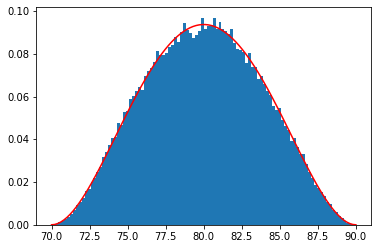

In [5]:
rv80 = [ rv(mean=80, delta=10) for i in range(100000) ]
_ = plt.hist(rv80, bins=100, density=True)

X = np.linspace(70, 90, 100)
Y = pdfv(X, mean=80, delta=10)
_ = plt.plot(X, Y, color='red')

### Free Speed Generator

In [6]:
free_speed_bins = [ 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160]
free_speed_quantiles = np.cumsum([0, 0.006, 0.014, 0.052, 0.148, 0.27, 0.309, 0.143, 0.048, 0.01])

def free_speed_distribution():
    u = random.random() # generates uniformly distributed random number between 0 and 1
    for i in range(len(free_speed_quantiles)):
        if u<free_speed_quantiles[i+1]:
            p = (u-free_speed_quantiles[i])/(free_speed_quantiles[i+1]-free_speed_quantiles[i])
            return free_speed_bins[i]*p+free_speed_bins[i+1]*(1-p)
        
free_speed_data = [ free_speed_distribution() for i in range(1200)]
free_speed_kernel = stats.gaussian_kde(free_speed_data)

free_speeds = np.arange(30, 191)
free_speed_cdf = [ free_speed_kernel.integrate_box_1d(30, i) for i in free_speeds ]

def random_free_speed():
    u = random.random() # generates uniformly distributed random number between 0 and 1
    for i in range(len(free_speeds)):
        if u<free_speed_cdf[i+1]:
            p = (u-free_speed_cdf[i])/(free_speed_cdf[i+1]-free_speed_cdf[i])
            return free_speeds[i]*p+free_speeds[i+1]*(1-p)

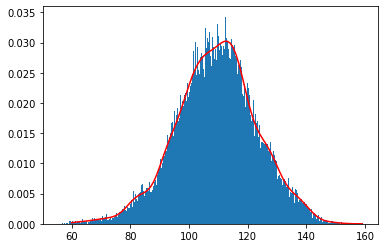

In [7]:
speeds = [ random_free_speed() for i in range(100000) ]
_ = plt.hist(speeds, bins=1000, density=True)
x = np.arange(60, 160, 1)
y = free_speed_kernel(x)
_ = plt.plot(x, y, color='red')

### Entities

### Lanes
The class `Lane` describes a segment of a lane. It has the width allowing only one vehicle at a point in the lane. i.e. there is no overtaking. Lane segments will be concatenated to form long stretches of road, and will be attached sidewise to each other to form multi lane infrastructure.

Lanes have a state consisting of the vehicles that are at a particular point in time on the lane segment. 

In [8]:
def normaliseDirection(d):
    d = d.lower()
    if d=='r' or d=='fast':
        return 'fast'
    elif d=='c' or d=='slightly fast':
        return 'slightly fast'
    elif d=='l' or d=='slow':
        return 'slow'
    else:
        return None

In [9]:
LANE_ID = 0

class Lane:
    
    ## some additional code
    def __init__(self, length, speedLimit):
        
        global LANE_ID
        self.id = LANE_ID
        LANE_ID += 1
        
        self.length = length
        self.speedLimit = speedLimit
        self.vehicles = []
        
        self.next = None
        self.prev = None
        
        # lane attached to the left/right
        self.left = None
        self.right = None
      
    # defines generic str() method for Lanes
    # extends the method with list of vehicles on the lane
    def __str__(self):
        l = "" if self.left is None else f" L:{self.left.id:d}"
        r = "" if self.right is None else f" R:{self.right.id:d}"
        vs = "" if len(self.vehicles)==0 else " "
        for v in self.vehicles:
            vs += str(v)
        return f"[{self.id:d} {int(self.length):d}m"+l+r+vs+"]" + \
                    ("-" + str(self.next) if self.next is not None else "")
    
    def getLane(self, direction):
        if direction=='slow':
            return self.left
        elif direction=='fast':
            return self.right
        else:
            return None

    # adding parallel lane on right side
    def attachRight(self, lane):
        self.right = lane
        lane.left = self
 
    # adding parallel lane on right side
    def attachLeft(self, lane):
        self.left = lane
        lane.right = self
     
    # constructs a number of lane segments of the same length
    # and attaches them to the right
    def widenRight(self):
        lane = self
        newLane = Lane(lane.length, lane.speedLimit)
        lane.attachRight(newLane)
        while lane.next is not None:
            lane = lane.next
            newLane = Lane(lane.length, lane.speedLimit)
            lane.attachRight(newLane)
            newLane.prev = lane.prev.right
            newLane.prev.next = newLane
        return self.right
            
    # constructs a number of lane segments of the same length
    # and attaches them to the right
    def widenLeft(self):
        lane = self
        newLane = Lane(lane.length, lane.speedLimit)
        lane.attachLeft(newLane)
        while lane.next is not None:
            lane = lane.next
            newLane = Lane(lane.length, lane.speedLimit)
            lane.attachLeft(newLane)
            newLane.prev = lane.prev.left
            newLane.prev.next = newLane
        return self.left
        
    # defines concatenation of lanes
    def extend(self, lane):
        l = self
        while l.next is not None:
            l = l.next
        l.next = lane
        lane.prev = l
        return self
    
    def totalLength(self):
        total = self.length
        l = self
        while l.next is not None:
            l = l.next
            total += l.length
        return total
    
    ## additional code
    ## new generalised access method needed to calculate sideway view
    ## returns all vehicles between pos+distFrom and pos+distTo
    def at(self, pos, distFrom=-CAR_LENGTH/2, distTo=CAR_LENGTH/2):
        # make sure that the position of all cars is accurate 
        # at this point in time
        for v in self.vehicles:
            v.updateOnly()
                # normally the list should be sorted, but just in case
        self.vehicles.sort(key=lambda v: v.pos)
        res = []
        for v in self.vehicles:
            if pos+distFrom < v.pos and v.pos < pos+distTo:
                res.append(v)
        # if the required distance reaches over the end of the lane segment
        if pos+distTo > self.length and self.next is not None:
            res = res + self.next.at(0, distFrom=0, distTo=distTo-(self.length-pos))
        if pos+distFrom < 0 and self.prev is not None:
            res = self.prev.at(self.prev.length, distFrom=pos+distFrom, distTo=0) + res
        return res
        
    def inFront(self, pos, far=FAR_AWAY_IN_FRONT):
        # make sure that the position of all cars is accurate 
        # at this point in time
        for v in self.vehicles:
            v.updateOnly()
        # normally the list should be sorted, but just in case
        self.vehicles.sort(key=lambda v: v.pos)
        for v in self.vehicles:
            if v.pos > pos:
                return v if v.pos-pos<far else None
        # there is none in front in this lance
        # if the free lane in front is long enough or there is no next lane
        if self.length-pos>far or self.next is None:
            return None
        else:
            return self.next.inFront(0, far=far-(self.length-pos))
        
    def behind(self, pos, far=FAR_AWAY_IN_BACK):
        # make sure that the position of all cars is accurate 
        # at this point in time
        for v in self.vehicles:
            v.updateOnly()
        # This time we sort in reverse order
        self.vehicles.sort(key=lambda v: v.pos, reverse=True)
        for v in self.vehicles:
            if v.pos < pos:
                return v if pos-v.pos<far else None
        # there is none behind in this lance
        # if the free lane in behind is long enough or there is no previous lane
        if pos>far or self.prev is None:
            return None
        else:
            return self.prev.behind(self.prev.length, far=far-pos)
        
    def enter(self, vehicle, pos=0):
        self.vehicles.insert(0, vehicle)
        vehicle.pos = pos
        vehicle.lane = self
        vehicle.rec.record(vehicle, event="enter lane")

    def leave(self, vehicle):
        vehicle.rec.record(vehicle, event="leave lane")
        vehicle.lane = None
        # in the meantime the vehicle may have have moved
        # to one of the next lane segments...
        lane = self
        while lane is not None:
            if vehicle in lane.vehicles:
                lane.vehicles.remove(vehicle)
                break
            else:
                lane = lane.next
    def laneEnds(self, pos, dist=1000):
        remaining = self.length - pos
        if remaining > dist:
            return None
        elif self.endOfLane:
            return remaining
        elif self.next is None:
            return None
        else:
            return self.next.laneEnds(0, dist = dist - remaining)

<b>Constructing two lanes of 3km</b>

In [10]:
VMAX = 120/3.6
LANE_ID = 0
l = Lane(1500, VMAX)
l.extend(Lane(1500, VMAX))
r = l.widenRight()
print("Left Lane: ", l)
print("Right Lane:", r)

Left Lane:  [0 1500m R:2]-[1 1500m R:3]
Right Lane: [2 1500m L:0]-[3 1500m L:1]


<b>Constructing a 3 km motorway that reduces from three lanes to two lanes after 2km.</b>

In [11]:
LANE_ID = 0
c = Lane(1000, VMAX)
while c.totalLength()<2000:
    c.extend(Lane(1000, VMAX))
l = c.widenLeft()
r = c.widenRight()
c.extend(Lane(1000, VMAX))
r = c.widenRight()

print("Left Lane:  ", l)
print("Centre Lane:", c)
print("Right Lane: ", r)

Left Lane:   [2 1000m R:0]-[3 1000m R:1]
Centre Lane: [0 1000m L:2 R:7]-[1 1000m L:3 R:8]-[6 1000m R:9]
Right Lane:  [7 1000m L:0]-[8 1000m L:1]-[9 1000m L:6]


### Vehicles
The class Vehicle is introduced as clone of the class P.

In [12]:
def isRunning(p):
    return p is not None and p.running

def isCrashed(p):
    return p is not None and p.crashed

In [13]:
VEHICLE_ID = 0

class Vehicle:
    def __init__(self, env, rec, 
                 startingLane=None, startingPos=0,
                 t0=0, x0=0, dx0=0, ddx0=0, dddx0=0, 
                 t=[], v=[], carlen = []):
        
        global VEHICLE_ID
        self.id = VEHICLE_ID
        VEHICLE_ID += 1
        
        self.a_min = -4 # [m/s²]
        self.a_max = 2.5 # [m/s²] corresponds to 0-100km/h om 12s
        
        self.env = env
        self.rec = rec
            
        self.startingLane = startingLane
        self.startingPos = startingPos
        self.lane = None
        self.pos = 0
        
        ## second lane reference during changing of lanes
        self.oldLane = None
            
        self.t0 = t0 #time
        self.x0 = x0 #dist
        self.dx0 = dx0 #vel
        self.ddx0 = ddx0 #acc
        self.dddx0 = dddx0 #change in acc
        self.carlen = carlen
        
        self.t = t
        self.v = v
        self.t_target = []
        self.v_target = []
        
        self.running = False
        self.crashed = False
        self.braking = False
        self.changingLane = False
        
        self.processRef = None
        self.env.process(self.process())
        
        ## this allows to trigger trace messages for
        ## the new feature Surround
        self.traceSurround = False
        self.traceOvertake = False
        self.traceBrake = False
    
    def __str__(self):
        return f"({self.id:d})"         
    
    def isNotFasterThan(self, other):
        return True if other is None else self.dx0 <= other.dx0
    
    def isNotSlowerThan(self, other):
        return True if other is None else other.dx0 <= self.dx0
    
    def updateOnly(self):
        if self.crashed:
            return False
        t = self.env.now
        if t < self.t0:
            return False
        if self.running and t > self.t0:
            dt = t - self.t0
            ddx = self.ddx0 + self.dddx0*dt
            dx = round(self.dx0 + self.ddx0*dt + self.dddx0*dt*dt/2,4)
            Δx = self.dx0*dt + self.ddx0*dt*dt/2 + self.dddx0*dt*dt*dt/6
            x = round(self.x0 + Δx, 2)
            self.t0, self.x0, self.dx0, self.ddx0 = t, x, dx, ddx
            
            self.pos = round(self.pos+Δx, 2)
            # update lane information if necessary
            if self.pos >= self.lane.length:
                nextPos = self.pos - self.lane.length
                nextLane = self.lane.next
                self.lane.leave(self)
                if nextLane is None:
                    self.rec.record(self, event='end')
                    self.running = False
                    return False
                else:
                    nextLane.enter(self, pos=nextPos)
        return True
        
    def update(self):
        active = self.updateOnly()
        if not active:
            return False
        
        self.surround = Surround(self)
        
        ## instead of direct link, call method
        inFront = self.surround.front
        if (isRunning(inFront) or isCrashed(inFront)) \
               and inFront.x0 < self.x0 + CAR_LENGTH:
            self.crash(inFront)
            return True

        if inFront is not None and not self.braking and \
                self.dx0 > inFront.dx0 and \
                self.x0 + CRITICAL_TIME_TOLERANCE*self.dx0 > inFront.x0:
            Δt = max(MIN_TIME_DIFF, (inFront.x0-self.x0)/self.dx0)
            self.setTarget(Δt, inFront.dx0)
            self.interruptProcess()
            return True
        
        ## new code: start overtaking maneuver by changing into fast lane
        if inFront is not None and \
                not self.braking and not self.changingLane and \
                self.dx0 > inFront.dx0 + MIN_SPEED_DIFF and \
                self.x0 + (LANE_CHANGE_TIME+CRITICAL_TIME_TOLERANCE)*self.dx0 > inFront.x0 and \
                self.surround.rightLane is not None and \
                self.surround.right is None and \
                self.isNotFasterThan(self.surround.rightFront) and \
                self.isNotSlowerThan(self.surround.rightBack):
            if self.traceOvertake:
                print(f"t={self.t0:7,.1f}s Overtaking v{self.id:d} overtakes v{inFront.id:d} at x={self.x0:7,.1f}m")
            self.setTarget(LANE_CHANGE_TIME, 'fast')
            self.interruptProcess()
            return True
            
        ## new code: end overtaking by returning to slow lane
        if self.surround.leftLane is not None and \
                not self.braking and not self.changingLane and \
                self.surround.left is None and \
                self.isNotFasterThan(self.surround.leftFront) and \
                self.surround.leftBack is None:
            if self.traceOvertake:
                print(f"t={self.t0:7,.1f}s Overtaking v{self.id:d} returns to slow lane at x={self.x0:7,.1f}m")
            self.setTarget(LANE_CHANGE_TIME, 'slow')
            self.interruptProcess()
            return True
     
    def setTarget(self, Δt, v):
        self.t_target = [ Δt ] + self.t_target
        self.v_target = [ v ] + self.v_target
      
    def process(self):

        # delay start to the given time t-
        if self.t0>self.env.now:
            yield self.env.timeout(self.t0-self.env.now)
        self.t0 = env.now
        self.running = True
        self.rec.startRecording(self)
        self.startingLane.enter(self, pos=self.startingPos)
        
        while self.running:
            self.updateOnly()
            
            self.surround = Surround(self)

            inFront = self.surround.front
            if inFront is not None:
                
                # if the car in front is slower and we are a bit too near on its heals...
                if inFront.dx0 < self.dx0 and \
                        inFront.x0 < self.x0 + CRITICAL_TIME_TOLERANCE*self.dx0:
                    if self.traceBrake:
                        print(f"t={self.t0:7,.1f}s Braking v{self.id:d} v={self.dx0:4.4f}m/s to {inFront.dx0:4.4f}")


                    yield from self.emergencyBraking(inFront.dx0)
                    if not isZero(self.dx0-inFront.dx0):
                        # after emergency breaking adjust to the speed of the car in front...
                        Δt = 2
                        self.setTarget(Δt, inFront.dx0)
                    continue 
        
            if len(self.t_target)==0:
                self.t_target = self.t.copy()
                self.v_target = self.v.copy()
                
            if len(self.t_target)>0:
                
                ## add code for explicit change of lane
                if type(self.v_target[0]) is str:
                    direction = normaliseDirection(self.v_target[0])
                    t = self.t_target[0]
                    self.t_target = self.t_target[1:]
                    self.v_target = self.v_target[1:]  
                    if self.lane.getLane(direction) is not None:
                        yield from self.changeLane(direction, t)
                
                ## the rest is what was there before
                else:
                    v0 = self.dx0
                    v1 = self.v_target[0]
                    t = self.t_target[0]
                    self.t_target = self.t_target[1:]
                    self.v_target = self.v_target[1:]  
                    if isZero(v1-v0):
                        yield from self.wait(t)
                    else:
                        yield from self.adjustVelocity(v1-v0, t)
            else:
                yield from self.wait(10)
        
        self.rec.stopRecording(self)
  
    def emergencyBraking(self, v):
        
        def emergencyBrakingProcess(v):
            self.rec.record(self, 'brake')
            minΔt = 0.2
            self.dddx0 = (self.a_min-self.ddx0)/minΔt      
            yield self.env.timeout(minΔt)
            
            self.updateOnly()
            self.dddx0=0
            self.ddx0=self.a_min
            v = min(v, self.dx0-2)
                # the brake time estimate is for perfect timing for 
                # autonomous cars. For manual driving leave out the
                # -minΔt/2 or use a random element.
            Δt = max(0.5, (v-self.dx0)/self.ddx0 - minΔt/2)
            yield self.env.timeout(Δt)
                
            self.updateOnly()
            self.dddx0 = -self.ddx0/minΔt      
            yield self.env.timeout(minΔt)
      
            self.updateOnly()
            self.ddx0 = 0
            self.dddx0 = 0

        
        ## The 'braking' bit prevents the interruption of an emergency breaking process 
        self.braking = True
        self.processRef = self.env.process(emergencyBrakingProcess(v))
        try:
            yield self.processRef
        except simpy.Interrupt:
            pass
        self.processRef = None
        self.braking = False
 
    ## make changeLane robust against interrupt:
    def changeLane(self, direction, Δt):
        
        # smoothly adjust velocity by Δv over the time Δt
        def changeLaneProcess(oldLane, newlane, Δt):
            self.updateOnly()
            self.rec.record(self, 'change '+direction)
            self.oldLane = oldLane
            newLane.enter(self, pos=self.pos) 
            self.ddx0 = 1
            self.dddx0 = 0
            yield self.env.timeout(Δt)
            self.oldLane.leave(self)
            self.lane = newLane
            self.oldLane = None
            self.rec.record(self, 'done change '+direction)
            self.updateOnly()
            self.ddx0 = 0
            self.dddx0 = 0
        
        ## keep record of current lane, as in case of aborting
        ## the lane change 
        ## when interrupted go back into original lane
        oldLane = self.lane
        newLane = self.lane.getLane(direction)
        self.changingLane = True
        try:
            self.processRef = self.env.process(changeLaneProcess(oldLane, newLane, Δt))
            yield self.processRef
            self.processRef = None
        except simpy.Interrupt:
            # if interrupted go quickly back into old lane
            # but this is not interruptible
            self.processRef = None
            self.env.process(changeLaneProcess(newLane, oldLane, Δt/4))
        self.changingLane = False

    def adjustVelocity(self, Δv, Δt):
        
        # smoothly adjust velocity by Δv over the time Δt
        def adjustVelocityProcess():
            self.updateOnly()
            minΔt = 0.1*Δt
            a = Δv/(Δt-minΔt)
            tt = Δt-2*minΔt
            
            self.dddx0 = (a-self.ddx0)/minΔt     
            yield self.env.timeout(minΔt)
            
            self.updateOnly()
            self.dddx0 = 0
            self.ddx0 = a
            yield self.env.timeout(tt)
            
            self.updateOnly()
            self.dddx0 = -a/minΔt
            yield self.env.timeout(minΔt)
        
            self.updateOnly()
            self.dddx0 = 0
            self.ddx0 = 0
        
        self.processRef = self.env.process(adjustVelocityProcess())
        try:
            yield self.processRef
        except simpy.Interrupt:
            self.dddx0 = 0
            pass
        self.processRef = None

    def wait(self, Δt):
         
        def waitProcess():
            yield self.env.timeout(Δt) 
        
        self.processRef = self.env.process(waitProcess())
        try:
            yield self.processRef
        except simpy.Interrupt:
            pass
        self.processRef = None

    def interruptProcess(self):
        if self.processRef is not None and self.processRef.is_alive:
            self.processRef.interrupt('change')
            
    def crash(self, other):
        
        def recordCrash(self):
            self.rec.record(self, 'crash')
            self.running = False
            self.crashed = True
            self.dx0 = 0
            self.ddx0 = 0
            self.dddx0 = 0
            
        if self.running:
            print(f"Crash p{self.id:d} into p{other.id:d} at t={self.t0:7.3f} x={self.x0:7.1f}")
            recordCrash(self)
            if other.running:
                recordCrash(other)

In [14]:
class Surround:
    
    def __init__(self, vehicle):
        
        def s(vehicle):
            if vehicle is None:
                return " "
            elif type(vehicle) is list:
                if len(vehicle)==1:
                    return s(vehicle[0])
                else:
                    res = "["
                    for v in vehicle:
                        if len(res)>1:
                            res += ','
                        res+=s(v)
                    res += "]"
                    return res
            else:
                return f"{vehicle.id:d}"
        
        # For each of the directions None means that there is no 
        # vehicle in the immediate vicinity.
        # We initialise to a 'safe' value which can be easily detected
        # if something goes wrong
        
        self.leftBack = vehicle
        self.left = vehicle
        self.leftFront = vehicle
        self.back = vehicle
        self.vehicle = vehicle
        self.front = vehicle
        self.rightBack = vehicle
        self.right = vehicle
        self.rightFront = vehicle
        
        lane = vehicle.lane
        pos = vehicle.pos
        if lane is not None:
            self.lane = lane
            self.front = lane.inFront(pos)
            self.back = lane.behind(pos)
            
            self.rightLane = lane.right
            if self.rightLane is not None:
                if vehicle.oldLane == lane.right:
                    # drifting left
                    self.right = vehicle
                    self.rightFront = self.rightLane.inFront(pos)
                    self.rightBack = self.rightLane.behind(pos)
                else:
                    right = self.rightLane.at(pos)
                    if len(right)==0:
                        self.right = None
                    elif len(right)==1:
                        self.right = right[0]
                    else:
                        self.right = right

                    if self.right is None:
                        self.rightFront = self.rightLane.inFront(pos)
                        self.rightBack = self.rightLane.behind(pos)
                    else:
                        self.rightFront = None
                        self.rightBack = None
                
            self.leftLane = lane.left
            if self.leftLane is not None:
                if vehicle.oldLane == lane.left:
                    # drifting right
                    self.left = vehicle
                    self.leftFront = self.leftLane.inFront(pos)
                    self.leftBack = self.leftLane.behind(pos)
                else:
                    left = self.leftLane.at(pos)
                    if len(left)==0:
                        self.left = None
                    elif len(left)==1:
                        self.left = left[0]
                    else:
                        self.left = left
                        
                    if self.left is None:
                        self.leftFront = self.leftLane.inFront(pos)
                        self.leftBack = self.leftLane.behind(pos)
                    else:
                        self.leftFront = None
                        self.lefttBack = None
                    
        if vehicle.traceSurround:
            print(f"surround t={self.vehicle.env.now:6.2f} " +
                  "|" +
                  ("" if self.leftLane is None else 
                      f"|{s(self.leftBack):s}>{s(self.left):s}>{s(self.leftFront):s}") +
                  f"|{s(self.back):s}>{s(self.vehicle):s}>{s(self.front):s}|" +
                  ("" if self.rightLane is None else
                      f"{s(self.rightBack):s}>{s(self.right):s}>{s(self.rightFront):s}|") +
                  "|"
                 )

### Recorder


In [15]:
class SimpleRecorder:
    
    def __init__(self, env, startTime, stopTime, timeStep):
        
        global VEHICLE_ID, LANE_ID
        VEHICLE_ID = 0
        LANE_ID = 0
        
        self.env = env
        self.startTime = startTime
        self.stopTime = stopTime
        self.timeStep = timeStep
        self.vehiclesToTrace = []
        self.vehicles = []
        self.data = pd.DataFrame(columns=['t', 'x', 'v', 'a', 'id','length', 'lane', 'oldLane', 'pos', 'event'])

    # runs the simulation
    def run(self):       
        self.env.process(self.process())
        self.env.run(self.stopTime+self.timeStep)
        
    def startRecording(self, p):
        self.vehicles.append(p)
        
    def stopRecording(self, p):
        self.vehicles.remove(p)
        
    def record(self, p=None, event='timer'):
        if p is not None:
            if p.updateOnly():
                laneId = None if p.lane is None else p.lane.id
                oldLaneId = None if p.oldLane is None else p.oldLane.id
                if p.running or event!='timer':
                    ix = len(self.data)
                    self.data.loc[ix]=[self.env.now, p.x0, p.dx0, p.ddx0, p.id, p.carlen, laneId, oldLaneId, p.pos, event] 
                    if event=='timer':
                        p.update()            
        else:
            for p in self.vehicles:
                self.record(p)
        
    def getData(self):
        return self.data.copy(deep=True)
    
    def getEvents(self):
        return self.data[self.data.event!='timer'].copy(deep=True)

    def process(self):
        yield self.env.timeout(self.startTime-self.env.now)
        while self.env.now <= self.stopTime:
            self.record()
            yield self.env.timeout(self.timeStep)
            
    def plot(self, x, y, 
             vehicles=None, 
             xmin=None, xmax=None, ymin=None, ymax=None):
        columns = ['t', 'x', 'v', 'a']
        labels = ['Time [s]', 'Position [m]', 'Velocity [m/s]', 'Acceleration [m/s²]']
        xindex = columns.index(x)
        yindex = columns.index(y)
        
        plt.figure(figsize=(6, 4), dpi=120)
        if xmin is not None and xmax is not None:
            plt.xlim((xmin, xmax))
        if ymin is not None and ymax is not None:
            plt.ylim((ymin, ymax))
        
        if vehicles is None:
            vehicles = list(self.data.id.unique())
        for id in vehicles:
            df = self.data[self.data.id==id]
            plt.plot(x, y, '', data=df)
            plt.xlabel(labels[xindex])
            plt.ylabel(labels[yindex])
            
            # use small circle to indicate emergency braking
            db = df[df.event=='brake']
            for i in range(len(db)):
                X = db.iloc[i, xindex]
                Y = db.iloc[i, yindex]
                plt.plot([X], [Y], 'ro')

            # use black 'x' as crash indicator
            dc = df[df.event=='crash']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], 'xk')
            
            # use black right pointing triangle
            # to indicate that a vehicle 
            # was changing into the fast lane
            dc = df[df.event=='change fast']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], '>k')
                
            # use black left pointing triangle
            # to indicate that a vehicle 
            # was changing into the slow lane
            dc = df[df.event=='done change slow']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], '<k')
                
            # use black diamond to indicate that
            # a vehicle ran out of track
            dc = df[df.event=='end']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], 'Dk')
                
        plt.grid(True)

### Load Data

In [16]:
def loadData(filename):  
    data = pd.read_csv(filename)
    r = Recorder()
    if list(data.columns) == list(r.data.columns):
        r.data = data
        return r
    else:
        return None

### Comparing Data

In [17]:
def sameData(r1, r2):
    try:
        return all(r1.getData() == r2.getData())
    except ValueError:
        return False

### Testing New Functionality

### 1. Controlled change of lane

In [18]:
VMAX = 120/3.6
N = 35
env = simpy.Environment()
rec = SimpleRecorder(env, 0, 10, 0.5)
car =  random.randint(4,6) 

c = Lane(1000, VMAX)
while c.totalLength()<2000:
    c.extend(Lane(1000, VMAX))
l = c.widenLeft()
r = c.widenRight()
c.extend(Lane(1000, VMAX))
r = c.widenRight()

for i in range(N):
    for i in range(N): 
        x = random.randint(0,2)
        if x == 0:
            s = l
        elif x == 1:
            s = c
        else:
            s = r
            
v = Vehicle(env, rec, startingLane=s, dx0=20, t=[2, 2, 2, 2, 10], v=[20, 'R', 20, 20, 20], carlen=car )
v.traceOvertake=True
rec.run()

t=    0.0s Overtaking v0 returns to slow lane at x=    0.0m
t=    5.5s Overtaking v0 returns to slow lane at x=  124.7m
t=    9.0s Overtaking v0 returns to slow lane at x=  214.0m


In [19]:
rec.getData()

,t,x,v,a,id,length,lane,oldLane,pos,event
0,0,0,20,0,0,6,7,None,0,enter lane
1,0,0,20,0,0,6,7,None,0,timer
2,0,0,20,0,0,6,7,None,0,change slow
3,0,0,20,0,0,6,0,7,0,enter lane
4,0.5,10.12,20.5,1.0,0,6,0,7,10.12,timer
5,1.0,20.49,21.0,1.0,0,6,0,7,20.49,timer
6,1.5,31.11,21.5,1.0,0,6,0,7,31.11,timer
7,2.0,41.98,22.0,1.0,0,6,0,7,41.98,timer
8,2.5,53.1,22.5,1.0,0,6,0,7,53.1,timer
9,3,64.47,23.0,1.0,0,6,0,7,64.47,leave lane


In [20]:
# Save to csv file
changelane = rec.getData()
changelane.to_csv (r'controlled_change_lane.csv', index = False, header = True)

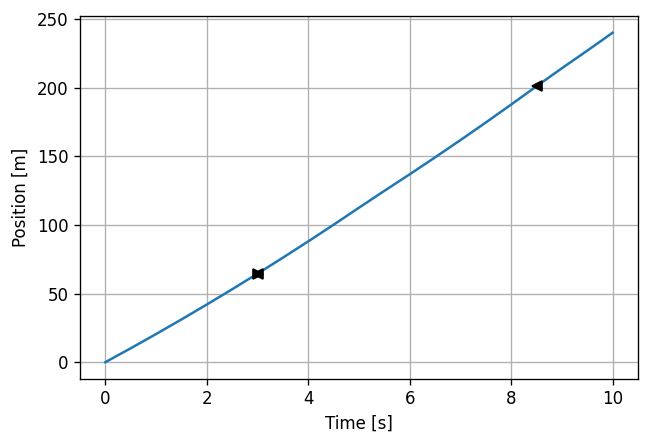

In [21]:
rec.plot('t', 'x')

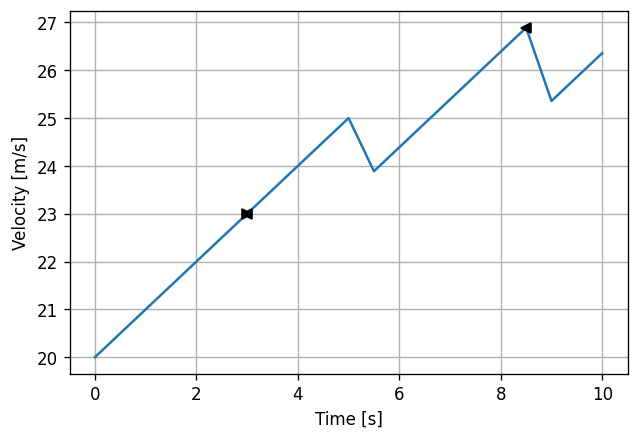

In [22]:
rec.plot('t', 'v')

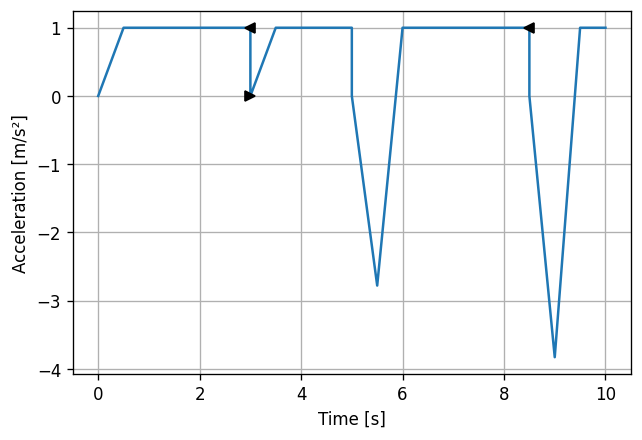

In [23]:
rec.plot('t', 'a')

### 2. Acceleration  and Deceleration 

In [24]:
VMAX = 120/3.6
env = simpy.Environment()
rec = SimpleRecorder(env, 0, 100, 1)


c = Lane(1000, VMAX)
while c.totalLength()<2000:
    c.extend(Lane(1000, VMAX))
l = c.widenLeft()
r = c.widenRight()
c.extend(Lane(1000, VMAX))
r = c.widenRight()


Vehicle(env, rec, startingLane = l, dx0=10, t=[20, 20, 40, 20], v=[30, 30, 20, 20])
rec.run()

In [25]:
rec.getData()

,t,x,v,a,id,length,lane,oldLane,pos,event
0,0,0,10,0,0,[],2,None,0,enter lane
1,0,0,10,0,0,[],2,None,0,timer
2,1,10.09,10.2778,0.555556,0,[],2,None,10.09,timer
3,2,20.74,11.1111,1.111111,0,[],2,None,20.74,timer
4,3,32.41,12.2222,1.111111,0,[],2,None,32.41,timer
...,...,...,...,...,...,...,...,...,...,...
81,78,1959.89,20.1379,-0.138886,0,[],3,None,959.89,timer
82,79,1979.97,20.0337,-0.069443,0,[],3,None,979.97,timer
83,80,1999.98,19.999,0,0,[],3,None,999.98,timer
84,81,2019.98,19.999,0.000028,0,[],3,None,1019.98,leave lane


In [26]:
# Save to csv file
acc_dec = rec.getData()
acc_dec.to_csv (r'accelleration_decelleration.csv', index = False, header = True)

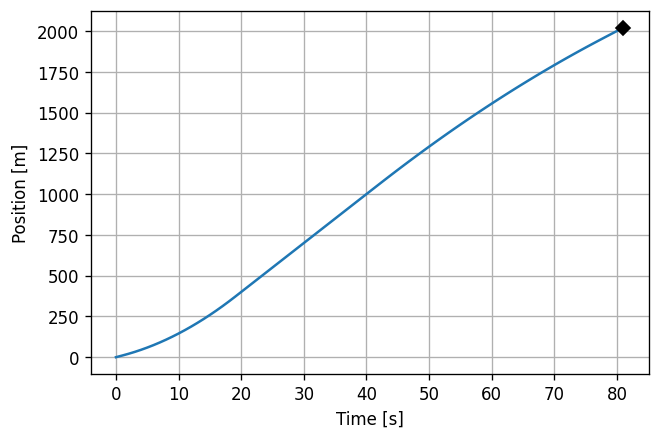

In [27]:
rec.plot('t', 'x')

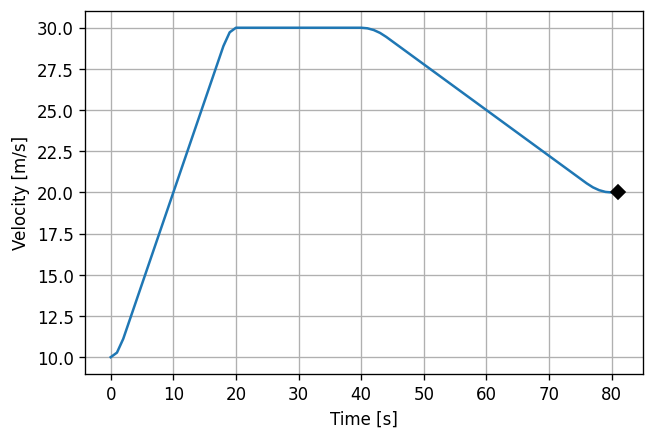

In [28]:
rec.plot('t', 'v')

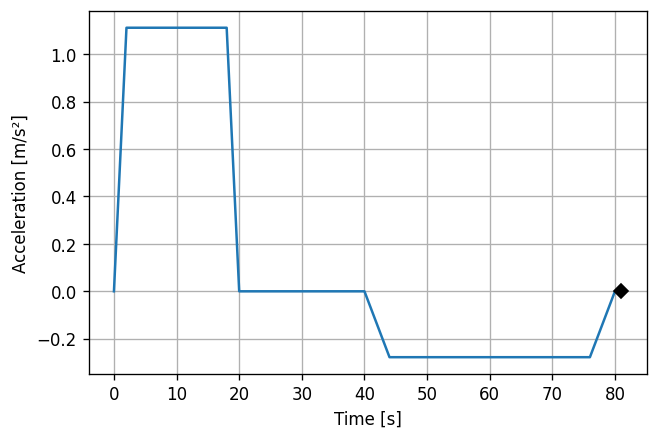

In [29]:
rec.plot('t', 'a')

<b> Testing vehicles with random speed </b>

In [30]:
SLOW_CYCLE = 100
def randomIntervals(cycles):
    #return [ random.expovariate(1.0/SLOW_CYCLE)+10 for i in range(cycles) ] 
    return [ max(0, random.normalvariate(SLOW_CYCLE, SLOW_CYCLE/3)) for i in range(cycles) ]

In [31]:
times = randomIntervals(5)
print(times)

[65.94715994876799, 108.24253694833422, 121.91428683011121, 177.09120287188955, 104.48598346305613]


In [32]:
SPEED_VARIATION = 0.05
random.seed(13)
def randomSpeedVariation(vmax, cycles, cv=SPEED_VARIATION):
    return [ vmax + (-1)**i*abs(random.normalvariate(0, vmax*cv)) for i in range(cycles) ] 

In [33]:
speed = randomSpeedVariation(30, 5)
print(speed)

[31.970316714337258, 26.85593790908569, 31.051052581944614, 28.82819178410906, 30.692366060170666]


### 3. Multiple Vehicles with Varying Speeds

In [34]:
VMAX = 120/3.6
N = 25 # number of points
DT = 15 # time difference between start
random.seed(13)
env = simpy.Environment()
rec = SimpleRecorder(env, 0, 4000, 1)


c = Lane(1000, VMAX)
while c.totalLength()<2000:
    c.extend(Lane(1000, VMAX))
l = c.widenLeft()
r = c.widenRight()
c.extend(Lane(1000, VMAX))
r = c.widenRight()

for i in range(N):
    CYCLES = random.randint(4, 8)
    times = randomIntervals(CYCLES)
    speed = randomSpeedVariation(VMAX+i, CYCLES)
    car = random.randint(4,6)


    v = Vehicle(env, rec, startingLane=l, t0=i*DT, dx0=speed[-1], t=times, v=speed)
    v.traceOvertake = True
    
rec.run()

In [35]:
rec.getData()

,t,x,v,a,id,length,lane,oldLane,pos,event
0,0,0,32.704421,0,0,[],2,None,0,enter lane
1,0,0,32.704421,0,0,[],2,None,0,timer
2,1,32.7,32.705500,0.002208,0,[],2,None,32.7,timer
3,2,65.41,32.708800,0.004417,0,[],2,None,65.41,timer
4,3,98.12,32.714300,0.006625,0,[],2,None,98.12,timer
...,...,...,...,...,...,...,...,...,...,...
1281,393,1867.41,57.329500,0.04754,24,[],3,None,867.41,timer
1282,394,1924.76,57.377000,0.04754,24,[],3,None,924.76,timer
1283,395,1982.16,57.424500,0.04754,24,[],3,None,982.16,timer
1284,396,2039.61,57.472000,0.04754,24,[],3,None,1039.61,leave lane


In [36]:
# Save to csv file
multi_vehicle = rec.getData()
multi_vehicle.to_csv (r'multiple_vehicle_varying.csv', index = False, header = True)

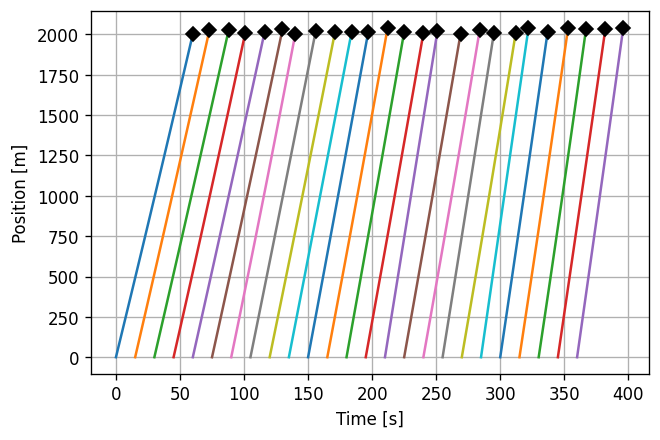

In [37]:
rec.plot('t', 'x')

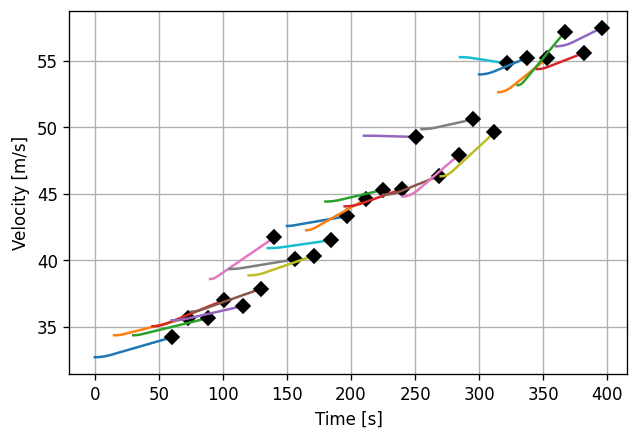

In [38]:
rec.plot('t', 'v')

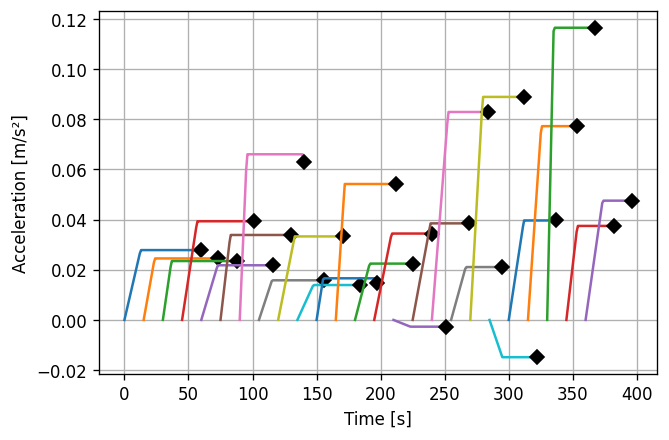

In [39]:
rec.plot('t', 'a')

### 4. Row of Vehicles with Varying Speed and Interarrival Times

In [40]:
LANE_ID = 0
VMAX = 45
N = 100 # number of points 
IAT = 20 # average interarrival time
random.seed(13)
env = simpy.Environment()
rec = SimpleRecorder(env, 0, 1000, 2)
iat = [ random.expovariate(1.0/IAT) for i in range(N) ]

c = Lane(1000, VMAX)
while c.totalLength()<2000:
    c.extend(Lane(1000, VMAX))
l = c.widenLeft()
r = c.widenRight()
c.extend(Lane(1000, VMAX))
r = c.widenRight()

t0 = 0
for i in range(N):
    for i in range(N): 
        x = random.randint(0,2)
        if x == 0:
            s = l
        elif x == 1:
            s = c
        else:
            s = r
    CYCLES = random.randint(4, 8)
    times = randomIntervals(CYCLES)
    speed = randomSpeedVariation(VMAX, CYCLES)
    t0 += iat[i]
    car = random.randint(4,6)
    v = Vehicle(env, rec, startingLane=s, t0=t0, dx0=speed[-1], t=times, v=speed, carlen=car)
    v.traceOvertake = True
    v.traceSurround = True
rec.run()

surround t= 11.58 || >0> | > > ||
surround t= 12.00 || >0> | > > ||
surround t= 14.00 || >0> | > > ||
surround t= 16.00 || >0> | > > ||
surround t= 18.00 || >0> | > > ||
surround t= 20.00 || >0> | > > ||
surround t= 22.00 || >0> | > > ||
surround t= 23.16 || > > | >1> ||
surround t= 24.00 || >0> | > > ||
surround t= 24.00 || > > | >1> ||
t=   24.0s Overtaking v1 returns to slow lane at x=   35.6m
surround t= 24.00 || > > | >1> ||
surround t= 26.00 || >0> | > > ||
surround t= 26.00 || > > | >1> | >1> ||
surround t= 27.00 || > > | >1> | > > ||
surround t= 28.00 || >0> | > > ||
surround t= 28.00 || > > | >1> | > > ||
t=   28.0s Overtaking v1 returns to slow lane at x=  213.4m
surround t= 28.00 || > > | >1> | > > ||
surround t= 30.00 || >0> | > > ||
surround t= 30.00 || >1> | >1> ||
surround t= 31.00 || >1> | > > ||
surround t= 32.00 || >0> | > > ||
surround t= 32.00 || >1> | > > ||
surround t= 34.00 || >0> | > > ||
surround t= 34.00 || >1> | > > ||
surround t= 34.75 || > > | >2> ||
surrou

surround t=140.00 || >11> | > > ||
surround t=142.00 || >8> | > > ||
surround t=142.00 || >9> | > > ||
surround t=142.00 || >10> | > > ||
surround t=142.00 || >11> | > > ||
surround t=144.00 || >8> | > > ||
surround t=144.00 || >9> | > > ||
surround t=144.00 || >10> | > > ||
surround t=144.00 || >11> | > > ||
surround t=146.00 || >8> | > > ||
surround t=146.00 || >9> | > > ||
surround t=146.00 || >10> | > > ||
surround t=146.00 || >11> | > > ||
surround t=148.00 || >9> | > > ||
surround t=148.00 || >10> | > > ||
surround t=148.00 || >11> | > > ||
surround t=150.00 || >9> | > > ||
surround t=150.00 || >10> | > > ||
surround t=150.00 || >11> | > > ||
surround t=150.56 || > > | >12> ||
surround t=152.00 || >9> | > > ||
surround t=152.00 || >10> | > > ||
surround t=152.00 || >11> | > > ||
surround t=152.00 || > > | >12> ||
t=  152.0s Overtaking v12 returns to slow lane at x=   64.3m
surround t=152.00 || > > | >12> ||
surround t=154.00 || >9> | > > ||
surround t=154.00 || >10> | > > ||
surr

surround t=250.00 || >19> | > > ||
surround t=250.00 || >20> | >20> ||
surround t=251.00 || >20> | > > ||
surround t=252.00 || >18> | > > ||
surround t=252.00 || >19> | > > ||
surround t=252.00 || >20> | > > ||
surround t=254.00 || >18> | > > ||
surround t=254.00 || >19> | > > ||
surround t=254.00 || >20> | > > ||
surround t=254.80 || > > | >21> | > > ||
surround t=256.00 || >18> | > > ||
surround t=256.00 || >19> | > > ||
surround t=256.00 || >20> | > > ||
surround t=256.00 || > > | >21> | > > ||
t=  256.0s Overtaking v21 returns to slow lane at x=   54.1m
surround t=256.00 || > > | >21> | > > ||
surround t=258.00 || >18> | > > ||
surround t=258.00 || >19> | > > ||
surround t=258.00 || >20> | > > ||
surround t=258.00 || >21> | >21> ||
surround t=259.00 || >21> | > > ||
surround t=260.00 || >18> | > > ||
surround t=260.00 || >19> | > > ||
surround t=260.00 || >20> | > > ||
surround t=260.00 || >21> | > > ||
surround t=262.00 || >18> | > > ||
surround t=262.00 || >19> | > > ||
surround 

surround t=364.00 || >27> | > > ||
surround t=364.00 || >28> | > > ||
surround t=364.00 || >29> | > > ||
surround t=364.00 || >30> | > > ||
surround t=366.00 || >27> | > > ||
surround t=366.00 || >28> | > > ||
surround t=366.00 || >29> | > > ||
surround t=366.00 || >30> | > > ||
surround t=368.00 || >27> | > > ||
surround t=368.00 || >28> | > > ||
surround t=368.00 || >29> | > > ||
surround t=368.00 || >30> | > > ||
surround t=370.00 || >28> | > > ||
surround t=370.00 || >29> | > > ||
surround t=370.00 || >30> | > > ||
surround t=370.62 || > > | >31> | > > ||
surround t=372.00 || >28> | > > ||
surround t=372.00 || >29> | > > ||
surround t=372.00 || >30> | > > ||
surround t=372.00 || > > | >31> | > > ||
t=  372.0s Overtaking v31 returns to slow lane at x=   61.2m
surround t=372.00 || > > | >31> | > > ||
surround t=374.00 || >28> | > > ||
surround t=374.00 || >29> | > > ||
surround t=374.00 || >30> | > > ||
surround t=374.00 || >31> | >31> ||
surround t=375.00 || >31> | > > ||
surround t

surround t=476.00 || > > | >40> ||
t=  476.0s Overtaking v40 returns to slow lane at x=   55.2m
surround t=476.00 || > > | >40> ||
surround t=478.00 || >37> | > > ||
surround t=478.00 || >38> | > > ||
surround t=478.00 || >39> | > > ||
surround t=478.00 || > > | >40> | >40> ||
surround t=479.00 || > > | >40> | > > ||
surround t=480.00 || >37> | > > ||
surround t=480.00 || >38> | > > ||
surround t=480.00 || >39> | > > ||
surround t=480.00 || > > | >40> | > > ||
t=  480.0s Overtaking v40 returns to slow lane at x=  254.9m
surround t=480.00 || > > | >40> | > > ||
surround t=482.00 || >37> | > > ||
surround t=482.00 || >38> | > > ||
surround t=482.00 || >39> | > > ||
surround t=482.00 || >40> | >40> ||
surround t=483.00 || >40> | > > ||
surround t=484.00 || >38> | > > ||
surround t=484.00 || >39> | > > ||
surround t=484.00 || >40> | > > ||
surround t=486.00 || >38> | > > ||
surround t=486.00 || >39> | > > ||
surround t=486.00 || >40> | > > ||
surround t=486.43 || >41> | > > ||
surround t=4

surround t=594.00 || >48> | > > ||
surround t=594.00 || >49> | > > ||
surround t=594.00 || > > | >50> | >50> ||
surround t=595.00 || > > | >50> | > > ||
surround t=596.00 || >47> | > > ||
surround t=596.00 || >48> | > > ||
surround t=596.00 || >49> | > > ||
surround t=596.00 || > > | >50> | > > ||
t=  596.0s Overtaking v50 returns to slow lane at x=  238.4m
surround t=596.00 || > > | >50> | > > ||
surround t=598.00 || >47> | > > ||
surround t=598.00 || >48> | > > ||
surround t=598.00 || >49> | > > ||
surround t=598.00 || >50> | >50> ||
surround t=599.00 || >50> | > > ||
surround t=600.00 || >47> | > > ||
surround t=600.00 || >48> | > > ||
surround t=600.00 || >49> | > > ||
surround t=600.00 || >50> | > > ||
surround t=602.00 || >47> | > > ||
surround t=602.00 || >48> | > > ||
surround t=602.00 || >49> | > > ||
surround t=602.00 || >50> | > > ||
surround t=602.25 || >51> | > > ||
surround t=604.00 || >47> | > > ||
surround t=604.00 || >48> | > > ||
surround t=604.00 || >49> | > > ||
sur

surround t=698.00 || >56> | > > ||
surround t=698.00 || >57> | > > ||
surround t=698.00 || >58> | > > ||
surround t=698.00 || > > | >59> | >59> ||
surround t=699.00 || > > | >59> | > > ||
surround t=700.00 || >56> | > > ||
surround t=700.00 || >57> | > > ||
surround t=700.00 || >58> | > > ||
surround t=700.00 || > > | >59> | > > ||
t=  700.0s Overtaking v59 returns to slow lane at x=  217.5m
surround t=700.00 || > > | >59> | > > ||
surround t=702.00 || >56> | > > ||
surround t=702.00 || >57> | > > ||
surround t=702.00 || >58> | > > ||
surround t=702.00 || >59> | >59> ||
surround t=703.00 || >59> | > > ||
surround t=704.00 || >57> | > > ||
surround t=704.00 || >58> | > > ||
surround t=704.00 || >59> | > > ||
surround t=706.00 || >57> | > > ||
surround t=706.00 || >58> | > > ||
surround t=706.00 || >59> | > > ||
surround t=706.49 || >60> | > > ||
surround t=708.00 || >57> | > > ||
surround t=708.00 || >58> | > > ||
surround t=708.00 || >59> | > > ||
surround t=708.00 || >60> | > > ||
sur

surround t=799.14 || >68> | > > ||
surround t=800.00 || >65> | > > ||
surround t=800.00 || >66> | > > ||
surround t=800.00 || >67> | > > ||
surround t=800.00 || >68> | > > ||
surround t=802.00 || >65> | > > ||
surround t=802.00 || >66> | > > ||
surround t=802.00 || >67> | > > ||
surround t=802.00 || >68> | > > ||
surround t=804.00 || >65> | > > ||
surround t=804.00 || >66> | > > ||
surround t=804.00 || >67> | > > ||
surround t=804.00 || >68> | > > ||
surround t=806.00 || >65> | > > ||
surround t=806.00 || >66> | > > ||
surround t=806.00 || >67> | > > ||
surround t=806.00 || >68> | > > ||
surround t=808.00 || >65> | > > ||
surround t=808.00 || >66> | > > ||
surround t=808.00 || >67> | > > ||
surround t=808.00 || >68> | > > ||
surround t=810.00 || >66> | > > ||
surround t=810.00 || >67> | > > ||
surround t=810.00 || >68> | > > ||
surround t=810.72 || >69> | > > ||
surround t=812.00 || >66> | > > ||
surround t=812.00 || >67> | > > ||
surround t=812.00 || >68> | > > ||
surround t=812.00 ||

surround t=914.00 || >75> | > > ||
surround t=914.00 || >76> | > > ||
surround t=914.00 || >77> | > > ||
surround t=914.96 || > > | >78> | > > ||
surround t=916.00 || >75> | > > ||
surround t=916.00 || >76> | > > ||
surround t=916.00 || >77> | > > ||
surround t=916.00 || > > | >78> | > > ||
t=  916.0s Overtaking v78 returns to slow lane at x=   45.0m
surround t=916.00 || > > | >78> | > > ||
surround t=918.00 || >75> | > > ||
surround t=918.00 || >76> | > > ||
surround t=918.00 || >77> | > > ||
surround t=918.00 || >78> | >78> ||
surround t=919.00 || >78> | > > ||
surround t=920.00 || >75> | > > ||
surround t=920.00 || >76> | > > ||
surround t=920.00 || >77> | > > ||
surround t=920.00 || >78> | > > ||
surround t=922.00 || >75> | > > ||
surround t=922.00 || >76> | > > ||
surround t=922.00 || >77> | > > ||
surround t=922.00 || >78> | > > ||
surround t=924.00 || >75> | > > ||
surround t=924.00 || >76> | > > ||
surround t=924.00 || >77> | > > ||
surround t=924.00 || >78> | > > ||
surround t

In [41]:
speed_int = rec.getData()
speed_int.to_csv (r'speed_interval.csv', index = False, header = True)

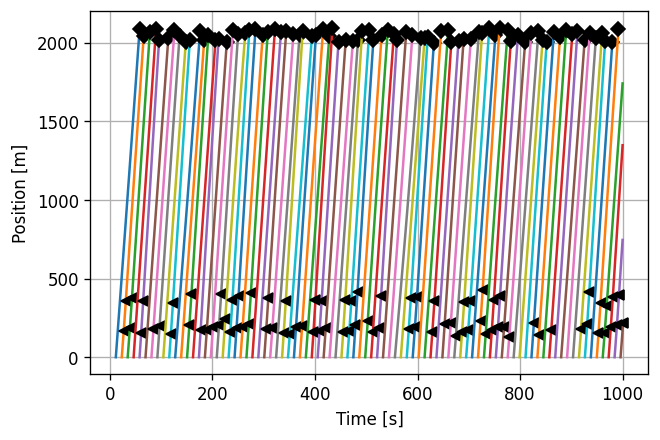

In [42]:
rec.plot('t','x')

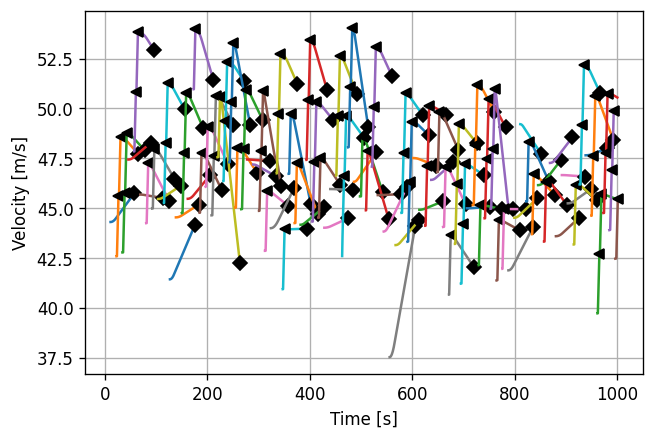

In [43]:
rec.plot('t','v')

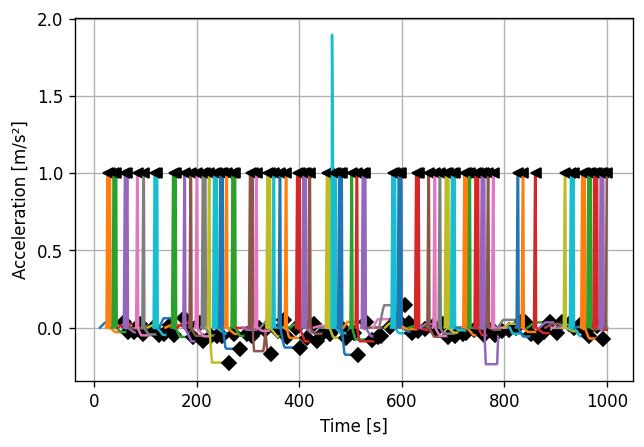

In [44]:
rec.plot('t','a')

## Simulations

In [45]:
def normaliseDirection(d):
    d = d.lower()
    if d=='r' or d=='fast':
        return 'fast'
    elif d=='l' or d=='slow':
        return 'slow'
    else:
        return None

### Lane

In [46]:
LANE_ID = 0

class Lane:
    
    def __init__(self, rec, length, speedLimit=None, merge=None):
        
        global LANE_ID
        self.id = LANE_ID
        LANE_ID += 1
      
        self.rec = rec
        self.x0 = 0
        self.length = length
        
        # speed limit on this lane segment in km/h
        self.speedLimit = speedLimit 
        
        # indicates that at the end of the lance traffic has to merge to the left or right
        self.merge = merge 
        
        self.vehicles = []
        
        self.next = None
        self.prev = None
                
        # lane attached to the left/right
        self.left = None
        self.right = None
        
        rec.recordLane(self)
      
    # defines generic str() method for Lanes
    def __str__(self):
        l = " L:--" if self.left is None else f" L:{self.left.id:0>2d}"
        r = " R:--" if self.right is None else f" R:{self.right.id:0>2d}"
        s = "" if self.speedLimit is None else f" speedLimit:{self.speedLimit:d}km/h"
        return f"[{self.id:0>2d} x={self.x0:3.1f}m l={self.length:3.1f}m"+l+r+s+"]" + \
                    ("\\" if self.merge=='R' else "") + \
                    ("/" if self.merge=='L' else "") + \
                    ("-" + str(self.next) if self.next is not None else "")
    
    def getLane(self, direction):
        if direction=='slow':
            return self.left
        elif direction=='fast':
            return self.right
        else:
            return None

    ## additional code    
    # adding parallel lane on right side
    def attachRight(self, lane):
        self.right = lane
        lane.left = self
        lane.x0 = self.x0
        lane.speedLimit = self.speedLimit
 
    ## additional code 
    # adding parallel lane on right side
    def attachLeft(self, lane):
        self.left = lane
        lane.right = self
        lane.x0 = self.x0
        lane.speedLimit = self.speedLimit
     
    ## additional code 
    # constructs a number of lane segments of the same length
    # and attaches them to the right
    def widenRight(self):
        lane = self
        newLane = Lane(self.rec, lane.length)
        lane.attachRight(newLane)
        while lane.next is not None:
            lane = lane.next
            newLane = Lane(self.rec, lane.length)
            lane.attachRight(newLane)
            newLane.prev = lane.prev.right
            newLane.prev.next = newLane
        return self.right
            
    ## additional code 
    # constructs a number of lane segments of the same length
    # and attaches them to the right
    def widenLeft(self):
        lane = self
        newLane = Lane(self.rec, lane.length)
        lane.attachLeft(newLane)
        while lane.next is not None:
            lane = lane.next
            newLane = Lane(self.rec, lane.length)
            lane.attachLeft(newLane)
            newLane.prev = lane.prev.left
            newLane.prev.next = newLane
        return self.left
            
    # defines concatenation of lanes
    def extend(self, lane):
        l = self
        while l.next is not None:
            l = l.next
        l.next = lane
        lane.x0 = l.x0+l.length
        lane.prev = l
        return self
        
    def totalLength(self):
        total = self.length
        l = self
        while l.next is not None:
            l = l.next
            total += l.length
        return total
    
    def between(self, posBack, posFront):
        # make sure that the position of all cars is accurate 
        # at this point in time
        for v in self.vehicles:
            v.updateOnly()
                # normally the list should be sorted, but just in case
        self.vehicles.sort(key=lambda v: v.pos)
        res = []
        for v in self.vehicles:
            if posBack < v.pos and v.pos-v.length < posFront:
                res.append(v)
        # if the required distance reaches over the end of the lane segment
        if posFront > self.length and self.next is not None:
            return res + self.next.between(0, posFront-self.length)
        elif posBack < 0 and self.prev is not None:
            return self.prev.between(self.prev.length+posBack, self.prev.length) + res
        else:
            return res
        
    def inFront(self, pos, far):
        # make sure that the position of all cars is accurate 
        # at this point in time
        for v in self.vehicles:
            v.updateOnly()
        # normally the list should be sorted, but just in case
        self.vehicles.sort(key=lambda v: v.pos)
        for v in self.vehicles:
            if v.pos > pos:
                return v if v.pos-pos<far else None
        # there is none in front in this lance
        # if the free lane in front is long enough or there is no next lane
        if self.length-pos>far or self.next is None:
            return None
        else:
            return self.next.inFront(0, far-(self.length-pos))

    def behind(self, pos, far):
        # make sure that the position of all cars is accurate 
        # at this point in time
        for v in self.vehicles:
            v.updateOnly()
        # This time we sort in reverse order
        self.vehicles.sort(key=lambda v: v.pos, reverse=True)
        for v in self.vehicles:
            if v.pos < pos:
                return v if pos-v.pos<far else None
        # there is none behind in this lance
        # if the free lane in behind is long enough or there is no previous lane
        if pos>far or self.prev is None:
            return None
        else:
            return self.prev.behind(self.prev.length, far-pos)
        
    def enter(self, vehicle, pos=0, laneChange=False):
        self.vehicles.insert(0, vehicle)
        vehicle.pos = pos
        vehicle.lane = self
        vehicle.rec.record(vehicle, event="enter lane"+(f" {self.id:d}" if laneChange else ""))

    def leave(self, vehicle, laneChange=False):
        vehicle.rec.record(vehicle, event="leave lane"+(f" {self.id:d}" if laneChange else ""))
        vehicle.lane = None
        self.vehicles.remove(vehicle)

In [47]:
def isRunning(p):
    return p is not None and p.running

def isCrashed(p):
    return p is not None and p.crashed

### Vehicle

In [48]:
VEHICLE_ID = 0
VEHICLE_LENGTH = [4, 4, 4, 4, 6, 6, 6, 12, 12, 12]
SPEED_VARIABILITY = ['LESS', 'LESS', 'MEDIUM', 'MEDIUM', 'MEDIUM', 'MEDIUM', 'MEDIUM', 'HIGH', 'HIGH', 'HIGH']
#Autonomous: 4 [m] => 40%
#Electrical: 6 [m] => 30%
#Trucks: 12 [m] => 30%
class Vehicle:
    def __init__(self, rec, 
                 startingLane=None, startingPos=0,
                 t0=0, x0=0, dx0=0, ddx0=0, dddx0=0, 
                 vmax=None, vmax_var=None,
                 t=[], v=[]):
        
        global VEHICLE_ID
        self.id = VEHICLE_ID
        VEHICLE_ID += 1
        
        self.a_brake = -4.0 # [m/s²]   Tesla: -8.0 # [m/s²]
        self.a_coast = -0.6 # [m/s²]   Tesla: -1.8 # [m/s²]   
        self.a_max =    2.5 # [m/s²]   Tesla:  4.6 # [m/s²] 
                            # Note: 2.5m/s² corresponds to 0-100km/h om 11s
        self.length = VEHICLE_LENGTH[random.randint(0, 9)] # [m]  Length of the vehicle 
        
        self.absolute_speed_time_tolerance = 2 # [s]
        self.relative_speed_time_tolerance = 5 # [s]
        self.far_away_in_front = 200 # [m]
        self.far_away_in_back = 80 # [m]
        self.min_action_time = 0.5 # [s]  
        
        self.lane_change_time = 3 # [s] 
        self.min_speed_diff = 2 # [m/s]
        
        ## if not None the preferred max free velocity
        self.vmax = vmax
        self.vmax_variation = vmax_var if vmax_var is not None else 0.05
        self.timing = 100 # [s]
        self.timing_variation = 0.30 
        
        self.env = rec.env
        self.rec = rec
            
        self.startingLane = startingLane
        self.startingPos = startingPos
        self.lane = None
        self.pos = 0
        
        # speedLimit once recognised
        self.speedLimit = None
        
        ## second lane reference during changing of lanes
        self.oldLane = None
        
        self.alternator = 0
            
        self.t0 = t0
        self.x0 = x0    # [m] the reference point is on the front of the vehicle
                        # the body of the vehicle of the given length is behind.
        self.dx0 = dx0
        self.ddx0 = ddx0
        self.dddx0 = dddx0

        self.t_target = t
        self.v_target = v
        # while there is an adjustment of velocity in progress
        # the current_target is set
        self.current_target = None

        # trace flags
        self.traceAdjustVelocity = False
        self.traceInterrupt = False
        self.traceBraking = False
        self.traceCrash = False
        self.traceSurround = False
        self.traceOvertaking = False
 
        # start process
        self.running = False
        self.crashed = False
                
        # Flags used for temporarily exclusive behaviour
        self.laneChangeControl = False 
                # This flag is used to block automatic overtaking
                # while processing explicit lane change control
        self.braking = False
                # This flag is used to prevent interrupting braking for braking
        self.changingLane = False
                # This flag is used to prevent interrupting lanechanging
        
        self.processRef = None
        self.env.process(self.process())
    
    def trace(self, message):
        print(f"t={self.t0:7,.1f}s x={self.x0:7,.1f}m v{self.id:d}", message)
        
    def isNotFasterThan(self, other):
        return True if other is None else self.dx0 <= other.dx0
    
    def isNotSlowerThan(self, other):
        return True if other is None else other.dx0 <= self.dx0
    
    ## adapted to handle lane information
    def updateOnly(self):
        t = self.env.now
        if t < self.t0 or not self.running:
            return False
        if t > self.t0:
            dt = t - self.t0
            ddx = self.ddx0 + self.dddx0*dt
            dx = self.dx0 + self.ddx0*dt + self.dddx0*dt*dt/2
            Δx = self.dx0*dt + self.ddx0*dt*dt/2 + self.dddx0*dt*dt*dt/6
            x = round(self.x0 + Δx, 2)
            self.t0, self.x0, self.dx0, self.ddx0 = t, x, dx, ddx
            
            ## begin additional code
            self.pos = round(self.pos+Δx, 2)
            # update lane information if necessary
            if self.pos >= self.lane.length:
                nextPos = self.pos - self.lane.length
                nextLane = self.lane.next
                self.lane.leave(self)
                if nextLane is None:
                    self.oldLane = None
                    self.rec.record(self, event='end')
                    self.running = False
                    return False
                else:
                    nextLane.enter(self, pos=nextPos)
            ## end additional code
            
        return True
        
    ## minor change only
    def update(self):
        
        self.surround = Surround(self)
        
        ## instead of direct link, call method
        inFront = self.surround.front
        
        # if there is a running or crashed vehicle in front and
        # we have crashed into the rear end of that vehicle
        if inFront is not None and inFront.x0-inFront.length < self.x0:
            self.crash(inFront)

        # if the speedLimit changes...
        elif self.speedLimit != self.lane.speedLimit:
            self.speedLimit = self.lane.speedLimit
            if self.speedLimit is None:
                # end of speed limit, return to default behaviour
                if self.vmax is not None and self.vmax>self.dx0:
                    Δt = max(self.min_action_time, (self.vmax-self.dx0)/self.a_max)
                    self.setTarget(Δt, self.vmax)
            else:
                vmax = self.speedLimit/3.6
                vmax = rv(mean=vmax, delta=self.vmax_variation*vmax)
                if vmax<self.dx0:
                    # when the new speedLimit is lower than current speed, coast down
                    Δt = max(self.min_action_time, (self.dx0-vmax)/self.a_coast)
                    self.setTarget(Δt, vmax)
                else:
                    # when the new speedLimit is higher than current speed, accelerate at half max a_max
                    Δt = max(self.min_action_time, 2*(vmax-self.dx0)/self.a_max)
                    self.setTarget(Δt, vmax)
                
        # if at the end of the lane merging is required      
        elif self.lane.merge is not None and \
                not self.braking and not self.laneChangeControl and not self.changingLane:
            if self.lane.merge == 'R':
                if self.surround.rightLane is not None and \
                        self.surround.right is None and \
                        self.isNotFasterThan(self.surround.rightFront) and \
                        self.isNotSlowerThan(self.surround.rightBack):
                    self.setTarget(self.lane_change_time, 'fast')
            elif self.lane.merge == 'L':
                if self.surround.leftLane is not None and \
                        self.surround.left is None and \
                        self.isNotFasterThan(self.surround.leftFront) and \
                        self.isNotSlowerThan(self.surround.leftBack):
                    self.setTarget(self.lane_change_time, 'slow')                
        
        # start overtaking maneuver by changing into fast lane
        elif inFront is not None and \
                not self.braking and not self.laneChangeControl and not self.changingLane and \
                self.dx0 > inFront.dx0 + self.min_speed_diff and \
                self.x0 + (self.lane_change_time+self.absolute_speed_time_tolerance)*self.dx0 > inFront.x0-inFront.length and \
                self.surround.rightLane is not None and \
                self.surround.right is None and \
                self.isNotFasterThan(self.surround.rightFront) and \
                self.isNotSlowerThan(self.surround.rightBack):
            self.setTarget(self.lane_change_time, 'fast')

        # if there is a vehicle in front 
        # which drives slower and
        # the distance to that vehicle in front is at current speed
        # less than the critical time tolerance of this driver
        elif inFront is not None and \
                not self.braking and not self.laneChangeControl and not self.changingLane and \
                self.dx0 > inFront.dx0 and \
                self.x0 + self.absolute_speed_time_tolerance*self.dx0 > inFront.x0:
            # note that self.a_coast is a negative acceleration
            Δt = max(self.min_action_time, (inFront.dx0-self.dx0)/self.a_coast)
            if self.current_target is None or \
                    not isZero(self.current_target-inFront.dx0):
                self.setTarget(Δt, inFront.dx0)

        # end overtaking by returning to slow lane
        elif self.surround.leftLane is not None and \
                not self.braking and not self.laneChangeControl and not self.changingLane and \
                self.surround.leftLane.totalLength()-self.pos>100 and \
                self.surround.left is None and \
                self.isNotSlowerThan(self.surround.leftBack) and \
                self.surround.leftFront is None:
            self.setTarget(self.lane_change_time, 'slow')
     
    ## code remains unchanged
    def setTarget(self, t, v):
        self.t_target = [ t ] + self.t_target
        self.v_target = [ v ] + self.v_target
        self.interruptProcess()
      
    ## minor change only
    def process(self):

        # delay start to the given time t-
        if self.t0>self.env.now:
            yield self.env.timeout(self.t0-self.env.now)
        self.t0 = self.env.now
        self.running = True
        self.rec.startRecording(self)
        
        ## begin additional code
        ## enter the first lane
        self.startingLane.enter(self)
        ## end additional code
        
        while self.updateOnly():

            ## instead of direct link, call method
            inFront = self.lane.inFront(self.pos, self.far_away_in_front) \
                        if self.lane is not None else None
                
            # if the car in front is slower and we are a bit too near on its heals...
            if inFront is not None and inFront.dx0 < self.dx0 and \
                    inFront.x0-inFront.length < \
                        self.x0 + self.relative_speed_time_tolerance*(self.dx0-inFront.dx0):
                yield from self.emergencyBraking(inFront.dx0)
                if not isZero(self.dx0-inFront.dx0):
                    # after emergency breaking adjust to the speed of the car in front...
                    Δt = 1
                    self.setTarget(Δt, inFront.dx0)
                continue 
                    
            if len(self.t_target)>0:
                
                t_target = self.t_target[0]
                v_target = self.v_target[0]
                self.t_target = self.t_target[1:]
                self.v_target = self.v_target[1:]
                
                if type(v_target) is str:
                    
                    # explicit overtake commands temporarily
                    # disable overtaking
                    if v_target=='R':
                        self.laneChangeControl = True
                    elif v_target=='L':
                        self.laneChangeControl = False
                        
                    direction = normaliseDirection(v_target)
                    if self.lane.getLane(direction) is not None:
                        yield from self.changeLane(inFront, direction, t_target)
                
                ## the rest is what was there before
                else:
                    v0 = self.dx0
                    v1 = v_target
                    Δt = t_target
                    if isZero(v1-v0):
                        yield from self.continueAtSameSpeed(Δt)
                    else:
                        yield from self.adjustVelocity(v1-v0, Δt)
                    
            ## additional code
            elif self.vmax is not None:
                
                # if the explicit control strategy is exhausted and
                # a target maximum speed is set the vehicle will follow
                # a random speed around the target maximum speed

                ## additional code
                vmax = self.vmax
                if self.speedLimit is not None:
                    vmax = self.speedLimit/3.6
                    vmax = rv(mean=vmax, delta=self.vmax_variation*vmax)
                    
                # as long there is no vehicle in front or the vehicle in front
                # is far enough ahead
                if inFront is None or \
                    self.x0 + self.relative_speed_time_tolerance*(self.dx0-inFront.dx0) < inFront.x0:
                    v0 = self.dx0
                    self.alternator += 1
                    v1 = rv(mean=vmax, 
                            delta=self.vmax_variation*vmax, 
                            alternating=self.alternator,
                            rounding=2)
                    Δt = rv(mean=self.timing, 
                            delta=self.timing*self.timing_variation,
                            rounding=1)
                
                    yield from self.adjustVelocity(v1-v0, Δt)
                else:
                    yield from self.continueAtSameSpeed(10)
            else:
                yield from self.continueAtSameSpeed(10)
                
        self.rec.stopRecording(self)

    def crash(self, other):
        
        def recordCrash(v):
            v.rec.record(v, 'crash')
            v.running = False
            v.crashed = True
            # stop anything your are currently doing...
            v.interruptProcess()
            v.dx0 = 0
            v.ddx0 = 0
            v.dddx0 = 0
            
        if self.running:
            if self.traceCrash:
                self.trace(f"Crashed into v{other.id:d} at x={self.x0:7.1f}m")
            recordCrash(self)
            if other.running:
                recordCrash(other)
        
    def emergencyBraking(self, v):
        
        def emergencyBrakingProcess(v):
            
            if self.traceBraking:
                self.trace(f"Braking from v={self.dx0:4.1f}m/s to {v:4.1f}m/s")
           
            self.rec.record(self, 'brake')
            minΔt = 0.2
            self.dddx0 = (self.a_brake-self.ddx0)/minΔt      
            yield self.env.timeout(minΔt)
            
            self.updateOnly()
            self.dddx0=0
            self.ddx0=self.a_brake
            v = min(v, self.dx0-2)
                # the brake time estimate is for perfect timing for 
                # autonomous cars. For manual driving leave out the
                # -minΔt/2 or use a random element.
            Δt = max(0.5, (v-self.dx0)/self.ddx0 - minΔt/2)
            yield self.env.timeout(Δt)
                
            self.updateOnly()
            self.dddx0 = -self.ddx0/minΔt      
            yield self.env.timeout(minΔt)
      
            self.updateOnly()
            self.ddx0 = 0
            self.dddx0 = 0
            self.rec.record(self, 'brake end')
            
            if self.traceBraking:
                self.trace(f"Braking end  v={self.dx0:4.1f}m/s")

        ## The 'braking' bit prevents the interruption of an emergency breaking process 
        self.braking = True
        self.processRef = self.env.process(emergencyBrakingProcess(v))
        try:
            yield self.processRef
        except simpy.Interrupt:
            if self.traceInterrupt or self.traceBraking:
                self.trace(f"Braking interrupted at v={self.dx0:4,.1f}m/s")
            pass
        self.processRef = None
        self.braking = False
        
    def changeLane(self, inFront, direction, Δt):
     
        def changeLaneProcess(oldLane, newlane, Δt, trace=True):
            # self.updateOnly()
            if trace and self.traceOvertaking and inFront is not None and  direction=='fast':
                other = f"v{inFront.id:d} " if inFront is not None else ""
                self.trace(f"Overtaking {other:s} at x={self.x0:7,.1f}m")
                
            self.rec.record(self, 'change '+direction)
            self.oldLane = oldLane
            newLane.enter(self, pos=self.pos, laneChange=True) 
            self.ddx0 = 1
            self.dddx0 = 0
            yield self.env.timeout(Δt)
            
            self.updateOnly()
            if not self.running:
                return
            currentLane = self.lane
            self.oldLane.leave(self, laneChange=True)
            self.lane = currentLane
            self.oldLane = None
            self.ddx0 = 0
            self.dddx0 = 0
            self.rec.record(self, 'done change '+direction)
            
            if trace and self.traceOvertaking and direction=='slow':
                self.trace(f"Overtaking done return to slow lane at x={self.x0:7,.1f}m")
            # self.updateOnly()
        
        ## keep record of current lane, as in case of aborting
        ## the lane change 
        ## when interrupted go back into original lane
        self.changingLane = True
        self.updateOnly()
        oldLane = self.lane
        newLane = self.lane.getLane(direction)
        try:
            self.processRef = self.env.process(changeLaneProcess(oldLane, newLane, Δt))
            yield self.processRef
            self.processRef = None
        except simpy.Interrupt:
            if self.traceInterrupt and self.traceOvertaking:
                self.trace(f"Overtaking interrupted at x={self.x0:7,.1f}m")
            # if interrupted go quickly back into old lane
            # but this is not interruptible
            self.updateOnly()
            # it is possible that there was an intermittent change lane event
            while self.lane != newLane and newLane is not None:
                newLane = newLane.next
                oldLane = oldLane.next
            self.processRef = None
            self.env.process(changeLaneProcess(newLane, oldLane, Δt/4, trace=False))
        self.changingLane = False    
        
    # smoothly adjust velocity by Δv over the time Δt
    def adjustVelocity(self, Δv, Δt):
        
        # smoothly adjust velocity by Δv over the time Δt
        def adjustVelocityProcess():
            
            self.updateOnly()
            
            if self.traceAdjustVelocity:
                self.trace(f"Adjusting Velocity from v={self.dx0:4,.1f}m/s by Δv={Δv:4,.1f}m/s over {Δt:4,.1f}s")
            
            minΔt = 0.1*Δt
            a = Δv/(Δt-minΔt)
            tt = Δt-2*minΔt
            
            self.dddx0 = (a-self.ddx0)/minΔt   
            yield self.env.timeout(minΔt)
        
            self.updateOnly()
            self.dddx0 = 0
            self.ddx0 = a
            yield self.env.timeout(tt)
        
            self.updateOnly()
            self.dddx0 = -a/minΔt
            yield self.env.timeout(minΔt)
        
            self.updateOnly()
            self.dddx0 = 0
            self.ddx0 = 0
                    
            if self.traceAdjustVelocity:
                self.trace(f"Adjusted  Velocity to   v={self.dx0:4,.1f}m/s")
        
        # start process
        self.current_target = self.dx0 + Δv
        self.processRef = self.env.process(adjustVelocityProcess())
        try:
            # wait for the process to finish
            yield self.processRef
        except simpy.Interrupt:
            # in case this has been interrupted
            if self.traceInterrupt:
                self.trace(f"Adjusting Velocity interrupted at v={self.dx0:4,.1f}m/s")
            pass
        self.current_target = None
        self.processRef = None

    def continueAtSameSpeed(self, Δt):
        
        def continueAtSameSpeedProcess():
            # don't change the current velocity
            self.dddx0 = 0
            self.ddx0 = 0
            yield self.env.timeout(Δt)
        
        # start process
        self.processRef = self.env.process(continueAtSameSpeedProcess())
        try:
            # wait for the process to finish
            yield self.processRef
        except simpy.Interrupt:
            # in case this has been interrupted
            if self.traceInterrupt:
                self.trace(f"Constant Velocity interrupted at v={self.dx0:4,.1f}m/s")
            pass
        self.processRef = None

    def interruptProcess(self):
        if self.processRef is not None and self.processRef.is_alive:
            self.processRef.interrupt('There are more important things to do...')

### Surround

In [49]:
class Surround:
    
    def __init__(self, vehicle):
        
        # For each of the directions None means that there is no 
        # vehicle in the immediate vicinity.
        # We initialise to a 'safe' value which can be easily detected
        # if something goes wrong
        
        self.vehicle = vehicle
            
        self.leftBack = None
        self.left = None
        self.leftFront = None
        self.back = None

        self.front = None
        self.rightBack = None
        self.right = None
        self.rightFront = None
        
        lane = vehicle.lane
        posFront = vehicle.pos
        posBack = vehicle.pos-vehicle.length
        if lane is not None:
            self.lane = lane
            self.front = lane.inFront(posFront, self.vehicle.far_away_in_front)
            self.back = lane.behind(posBack, self.vehicle.far_away_in_back)
            
            self.rightLane = lane.right
            if self.rightLane is not None:
                if vehicle.oldLane == lane.right:
                    # drifting left
                    self.right = vehicle
                    self.rightFront = self.rightLane.inFront(posFront, self.vehicle.far_away_in_front)
                    self.rightBack = self.rightLane.behind(posBack, self.vehicle.far_away_in_back)
                else:
                    right = self.rightLane.between(posBack-10, posFront+10)
                    if len(right)==0:
                        # self.right = None
                        self.rightFront = self.rightLane.inFront(posFront+10, self.vehicle.far_away_in_front)
                        self.rightBack = self.rightLane.behind(posBack-10, self.vehicle.far_away_in_back)
                    else:
                        self.right = right[0]
                        # self.rightFront = None
                        # self.rightBack = None

            self.leftLane = lane.left
            if self.leftLane is not None:
                if vehicle.oldLane == lane.left:
                    # drifting right
                    self.left = vehicle
                    self.leftFront = self.leftLane.inFront(posFront, self.vehicle.far_away_in_front)
                    self.leftBack = self.leftLane.behind(posBack, self.vehicle.far_away_in_back)
                else:
                    left = self.leftLane.between(posBack-10, posFront+10)
                    if len(left)==0:
                        # self.left = None
                        self.leftFront = self.leftLane.inFront(posFront+10, self.vehicle.far_away_in_front)
                        self.leftBack = self.leftLane.behind(posBack-10, self.vehicle.far_away_in_back)
                    else:
                        self.left = left[0]
                        # self.leftFront = None
                        # self.lefttBack = None
                    
        if vehicle.traceSurround:
            
            def s(vehicle):
                if vehicle is None:
                    return " "
                elif type(vehicle) is list:
                    if len(vehicle)==1:
                        return s(vehicle[0])
                    else:
                        res = "["
                        for v in vehicle:
                            if len(res)>1:
                                res += ','
                            res+=s(v)
                        res += "]"
                        return res
                else:
                    return f"{vehicle.id:d}"

            print(f"surround t={self.vehicle.env.now:6.2f} " +
                  "|" +
                  ("" if self.leftLane is None else 
                      f"|{s(self.leftBack):s}>{s(self.left):s}>{s(self.leftFront):s}") +
                  f"|{s(self.back):s}>{s(self.vehicle):s}>{s(self.front):s}|" +
                  ("" if self.rightLane is None else
                      f"{s(self.rightBack):s}>{s(self.right):s}>{s(self.rightFront):s}|") +
                  "|"
                 )

### Recorder

In [50]:
class Recorder:
    
    def __init__(self, startTime=0, stopTime=0, timeStep=1):
        
        global VEHICLE_ID, LANE_ID
        VEHICLE_ID = 0
        LANE_ID = 0
        
        self.env = simpy.Environment()
        self.ps = []
        self.startTime = startTime
        self.stopTime = stopTime
        self.timeStep = timeStep
        self.data = pd.DataFrame(columns=['t', 'x', 'v', 'a', 'id', 'lane', 'oldLane', 'pos', 'event'])

    # runs the simulation
    def run(self):
        self.env.process(self.process())
        self.env.run(self.stopTime+self.timeStep)
    
    def process(self):
        yield self.env.timeout(self.startTime-self.env.now)
        while self.env.now <= self.stopTime:
            self.record()     
            yield self.env.timeout(self.timeStep)
            
    def startRecording(self, p):
        self.ps.append(p)
        self.record(p, event='start')
        
    def stopRecording(self, p):
        self.ps.remove(p)
        
    def record(self, p=None, event='timer'):
        if p is not None:
            if p.updateOnly() or event!='timer':
                laneId = -1 if p.lane is None else p.lane.id
                oldLaneId = -1 if p.oldLane is None else p.oldLane.id
                ix = len(self.data)
                self.data.loc[ix]=[self.env.now, p.x0, p.dx0, p.ddx0, p.id, \
                                   laneId, oldLaneId, p.pos, event]
                if event=='timer':
                    p.update()
        else:
            for p in self.ps:
                self.record(p, event)

    ## additional code: record lane information
    def recordLane(self, lane):
        ix = len(self.data)
        self.data.loc[ix]=[0, 0, 0, 0, 0, lane.id, -1, lane.length, 'lane info'] 

    ## additional code: record lane information
    def getLaneLength(self, laneId):
        lanes = self.data[self.data.event=='lane info']
        lane = lanes[lanes.lane==laneId]
        return lane.pos.iloc[0]
    
    def saveData(self, filename):
        self.data.to_csv(filename, index=False)
        
    def getData(self):
        return self.data.copy(deep=True)
    
    def getEvents(self):
        return self.data[self.data.event!='timer'].copy(deep=True)
    
    ## new code: computes traffic flow in vehicles/h at the end of a given lane
    ## based on 'leave lane' events proper (i.e. excluding overtaking)
    def flow(self, lane):
        df = self.data[self.data.event=='leave lane']
        df = df[df.lane==lane]
        if len(df)>1:
            # compensate for lane filling late or early running dry
            f = (len(df)-1)*3600/(df.t.max()-df.t.min())
            return round(f, 2)
        else:
            return 0

    ## new code: computes the average travelling time through a lane segment
    def avgTravelTime(self, laneId):
        d0 = self.data[self.data.event=='enter lane']
        d0 = d0[d0.lane==laneId]
        d1 = self.data[self.data.event=='leave lane']
        d1 = d1[d1.lane==laneId]
        times = []
        id0 = d0.id.unique()
        id1 = d1.id.unique()
        for id in id0:
            t0 = d0.t[d0.id==id].min()
            if id in id1:
                t1 = d1.t[d1.id==id].max()
                times += [ t1-t0 ]
        avg = 0
        if len(times)>0:
            avg = round(sum(times)/len(times), 2)
        return avg

    def avgSpeed(self, laneId):
        return round(3.6*self.getLaneLength(laneId)/self.avgTravelTime(laneId),2)
        
        
    ## new code: computes traffic density in vehicles/km for a given lane
    ## at a given moment in time. When no time is specified it returns a
    ## list of traffic densities over time.
    def density(self, laneId, time=None):
        timerEvents = self.data[self.data.event=='timer']
        times = timerEvents.t.unique()
        laneEvents = timerEvents[timerEvents.lane==laneId]
        laneLength = self.getLaneLength(laneId)
        
        if time is None:
            densities = []
            for t in times:
                events = laneEvents[laneEvents.t==t]
                d = len(events)*1000/laneLength
                densities.append(round(d,2))
            return sum(densities)/len(densities)
        
        # find the timestamp nearest to the requested time
        if time in times:
            t = time
        else:
            # take the nearest point in time
            diff = list((times-time)**2)
            t = times[diff.index(min(diff))]
        events = laneEvents[laneEvents.t==t]
        d = len(events)*1000/laneLength
        return round(d,2)
    
    def plot(self, x, y, 
             vehicles=None, style='', lw=1, decoration=True,
             x0=None, x1=None, y0=None, y1=None, fillColor=None, 
             xmin=None, xmax=None, ymin=None, ymax=None):
        columns = ['t', 'x', 'v', 'a']
        labels = ['Time [s]', 'Position [m]', 'Velocity [m/s]', 'Acceleration [m/s²]']
        xindex = columns.index(x)
        yindex = columns.index(y)
        
        plt.figure(figsize=(5, 3), dpi=120)
        if xmin is not None and xmax is not None:
            plt.xlim((xmin, xmax))
        if ymin is not None and ymax is not None:
            plt.ylim((ymin, ymax))
        
        if vehicles is None:
            vehicles = list(self.data.id.unique())
        for id in vehicles:
            df = self.data[self.data.id==id]
            plt.plot(x, y, style, lw=lw, data=df)
            plt.xlabel(labels[xindex])
            plt.ylabel(labels[yindex])
            
            if not decoration:
                continue
            
            # use small red circle to indicate emergency braking
            dc = df[df.event=='brake']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], 'ro')
                            
            db = df[df.event=='brake end']
            for i in range(len(db)):
                X = db.iloc[i, xindex]
                Y = db.iloc[i, yindex]
                plt.plot([X], [Y], marker='o', mec='r', fillstyle='none')

            # use black 'x' as crash indicator
            dc = df[df.event=='crash']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], 'xk')
                
            # use black Diamond to indicate that
            # a vehicle ran out of track
            dc = df[df.event=='end']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], 'Dk')
                
            # use black right pointing full triangle
            # to indicate that a vehicle started
            #  changing into the fast lane
            dc = df[df.event=='change fast']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], '>k')
                
            # use black right pointing hollow triangle
            # to indicate that a vehicle has finished
            # changing into the fast lane
            dc = df[df.event=='done change fast']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], marker='>', mec='k', fillstyle='none')

            # use black left pointing full triangle
            # to indicate that a vehicle started
            #  changing into the slow lane
            dc = df[df.event=='change slow']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], '<k')
                
            # use black left pointing hollow triangle
            # to indicate that a vehicle has finished
            # changing into the slow lane
            dc = df[df.event=='done change slow']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], marker='<', mec='k', fillstyle='none')
            
        # fill area with background color
        if fillColor is not None:
            if x0 is None:
                x0=self.data[x].min()
            if x1 is None:
                x1=self.data[x].max()
            if y0 is None:
                y0=self.data[y].min()
            if y1 is None:
                y1=self.data[y].max()
            plt.fill_between( [x0, x1], [y0, y0], [y1, y1], color=fillColor)
            
        plt.grid(True)

### Simulation

In [51]:
def simulation(n=[10], IAT=[10, 10, 10], VMAX=[120/3.6, 120/3.6, 120/3.6], 
               startTime=0, stopTime=50, step=1):
    rec = Recorder(startTime, stopTime, step)
    
    #Motorway architecture
    leftLane = Lane(rec, 1000)
    l1 = Lane(rec, 1000)
    leftLane.extend(l1)
    
    centerLane = Lane(rec, 1000)
    c1 = Lane(rec, 1000)
    centerLane.extend(c1)
    
    centerLane.attachLeft(leftLane)
    
    c2 = Lane(rec, 1000)
    centerLane.extend(c2)
    
    rightLane = centerLane.widenRight()
    
    mergeLane = Lane(rec, 300, merge='R')
    leftLane.extend(mergeLane)
    
    c2.attachLeft(mergeLane)
    c2.left = None
    c1.attachLeft(l1)


    print('LeftLane: {}'.format(leftLane))
    print('CenterLane: {}'.format(centerLane))
    print('RightLane: {}'.format(rightLane))
    
    if(len(n) == 1):
        while(n[0] % 3 != 0): n[0]+=1
    
        N = n[0]
        iat_lane1 = [ rv(IAT[0], delta=0.4*IAT[0]) for i in range(int(N / 3)) ]
        iat_lane2 = [ rv(IAT[1], delta=0.4*IAT[1]) for i in range(int(N / 3)) ]
        iat_lane3 = [ rv(IAT[2], delta=0.4*IAT[2]) for i in range(int(N / 3)) ]

        t = 0
        for i in range(int(N / 3)):
            t += iat_lane1[i]
            v = Vehicle(rec, startingLane=leftLane, t0=t, dx0=VMAX[0], vmax=VMAX[0], vmax_var=speedMapping(SPEED_VARIABILITY[random.randint(0, 9)]))
            v.traceCrash = True
            v.traceOvertaking = True

        t = 0
        for i in range(int(N / 3)):
            t += iat_lane2[i]
            v = Vehicle(rec, startingLane=centerLane, t0=t, dx0=VMAX[1], vmax=VMAX[1], vmax_var=speedMapping(SPEED_VARIABILITY[random.randint(0, 9)]))
            v.traceCrash = True
            v.traceOvertaking = True

        t = 0
        for i in range(int(N / 3)):
            t += iat_lane3[i]
            v = Vehicle(rec, startingLane=rightLane, t0=t, dx0=VMAX[2], vmax=VMAX[2], vmax_var=speedMapping(SPEED_VARIABILITY[random.randint(0, 9)]))
            v.traceCrash = True
            v.traceOvertaking = True
    else:
        iat_lane1 = [ rv(IAT[0], delta=0.4*IAT[0]) for i in range(int(n[0])) ]
        iat_lane2 = [ rv(IAT[1], delta=0.4*IAT[1]) for i in range(int(n[1])) ]
        iat_lane3 = [ rv(IAT[2], delta=0.4*IAT[2]) for i in range(int(n[2])) ]

        t = 0
        for i in range(int(n[0])):
            t += iat_lane1[i]
            v = Vehicle(rec, startingLane=leftLane, t0=t, dx0=20, vmax=VMAX[0], vmax_var=speedMapping(SPEED_VARIABILITY[random.randint(0, 9)]))
            v.traceCrash = True
            v.traceOvertaking = True

        t = 0
        for i in range(int(n[1])):
            t += iat_lane2[i]
            v = Vehicle(rec, startingLane=centerLane, t0=t, dx0=20, vmax=VMAX[1], vmax_var=speedMapping(SPEED_VARIABILITY[random.randint(0, 9)]))
            v.traceCrash = True
            v.traceOvertaking = True

        t = 0
        for i in range(int(n[2])):
            t += iat_lane3[i]
            v = Vehicle(rec, startingLane=rightLane, t0=t, dx0=20, vmax=VMAX[2], vmax_var=speedMapping(SPEED_VARIABILITY[random.randint(0, 9)]))
            v.traceCrash = True
            v.traceOvertaking = True
    
    rec.run()
    return rec

In [52]:
leftLane_N = 10
centerLane_N = 8
rightLane_N = 12
N = [leftLane_N, centerLane_N, rightLane_N]
rec = simulation(N, startTime=0, stopTime=300, step=1)

LeftLane: [00 x=0.0m l=1000.0m L:-- R:02]-[01 x=1000.0m l=1000.0m L:-- R:03]-[08 x=2000.0m l=300.0m L:-- R:04]\
CenterLane: [02 x=0.0m l=1000.0m L:00 R:05]-[03 x=1000.0m l=1000.0m L:01 R:06]-[04 x=2000.0m l=1000.0m L:-- R:07]
RightLane: [05 x=0.0m l=1000.0m L:02 R:--]-[06 x=1000.0m l=1000.0m L:03 R:--]-[07 x=2000.0m l=1000.0m L:04 R:--]
t=   12.0s x=   80.2m v10 Overtaking done return to slow lane at x=   80.2m
t=   15.0s x=  141.6m v18 Overtaking done return to slow lane at x=  141.6m
t=   28.0s x=  215.8m v19 Overtaking done return to slow lane at x=  215.8m
t=   43.0s x=  301.6m v20 Overtaking done return to slow lane at x=  301.6m
t=   44.0s x=  538.6m v11 Overtaking done return to slow lane at x=  538.6m
t=   75.0s x=1,004.9m v12 Overtaking done return to slow lane at x=1,004.9m
t=   78.0s x=1,491.8m v19 Overtaking done return to slow lane at x=1,491.8m
t=   86.0s x=2,025.0m v0 Overtaking v10  at x=2,025.0m
t=   88.0s x=1,179.3m v21 Overtaking done return to slow lane at x=1,179.3

### Trafic flow in veh/h

In [53]:
print('Left lane flow: \nsegment1: {} veh/h\nsegment2: {} veh/h'.format(rec.flow(0), rec.flow(1)))
print('--------')
print('Center lane flow: \nsegment1: {} veh/h\nsegment2: {} veh/h\nsegment3: {}'.format(rec.flow(2), rec.flow(3), rec.flow(4)))
print('--------')
print('Right lane flow: \nsegment1: {} veh/h\nsegment2: {} veh/h\nsegment3: {}'.format(rec.flow(5), rec.flow(6), rec.flow(7)))

Left lane flow: 
segment1: 437.38 veh/h
segment2: 571.96 veh/h
--------
Center lane flow: 
segment1: 363.64 veh/h
segment2: 280.0 veh/h
segment3: 663.59
--------
Right lane flow: 
segment1: 351.22 veh/h
segment2: 415.38 veh/h
segment3: 333.33


### Traffic density in veh/km

In [54]:
d1 = (rec.density(0, 100) + rec.density(2, 100) + rec.density(5, 100))
d2 = (rec.density(1, 100) + rec.density(3, 100) + rec.density(6, 100))
d3 = (rec.density(4, 100) + rec.density(7, 100))
print('Density of first segment: {} veh/km'.format((rec.density(0, 100) + rec.density(2, 100) + rec.density(5, 100))))
print('Density of second segment: {} veh/km'.format((rec.density(1, 100) + rec.density(3, 100) + rec.density(6, 100))))
print('Density of third segment: {} veh/km'.format((rec.density(4, 100) + rec.density(7, 100))))
print('Average trafic density on All lane: {} veh/km'.format((d1 + d2 + d3) / 3))

Density of first segment: 12.0 veh/km
Density of second segment: 11.0 veh/km
Density of third segment: 5.0 veh/km
Average trafic density on All lane: 9.333333333333334 veh/km


### Average travel time in s

In [55]:
print('Average travel time for first Segment: {} s'.format(rec.avgTravelTime(0)))

Average travel time for first Segment: 44.19 s


## Average speed in km/h

In [56]:
print('Average speed for first Segment: {} km/h'.format(rec.avgSpeed(0)))

Average speed for first Segment: 81.47 km/h


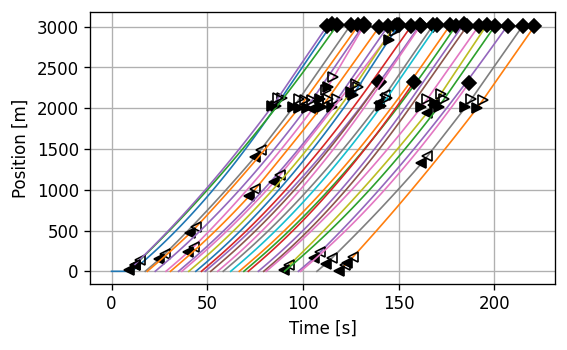

In [57]:
rec.plot('t', 'x')

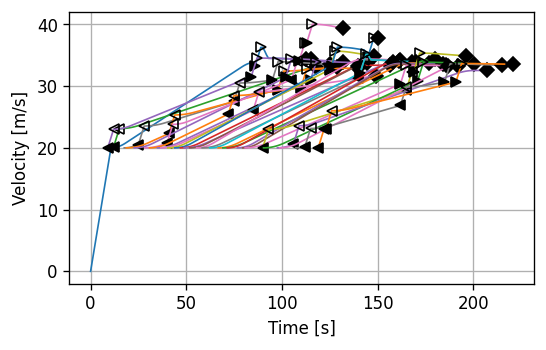

In [58]:
rec.plot('t', 'v')

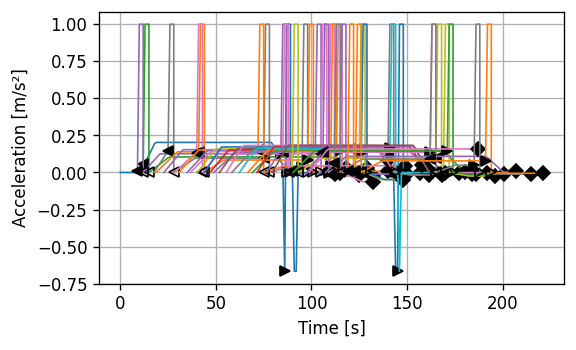

In [59]:
rec.plot('t', 'a')

In [60]:
rec.getData()

,t,x,v,a,id,lane,oldLane,pos,event
0,0,0,0,0,0,0,-1,1000,lane info
1,0,0,0,0,0,1,-1,1000,lane info
2,0,0,0,0,0,2,-1,1000,lane info
3,0,0,0,0,0,3,-1,1000,lane info
4,0,0,0,0,0,4,-1,1000,lane info
...,...,...,...,...,...,...,...,...,...
3557,218,2903.46,33.554544,-0.005558,29,4,-1,903.46,timer
3558,219,2937.01,33.548986,-0.005558,29,4,-1,937.01,timer
3559,220,2970.56,33.543428,-0.005558,29,4,-1,970.56,timer
3560,221,3004.1,33.53787,-0.005558,29,4,-1,1004.1,leave lane


In [61]:
# Save to csv file
simulations = rec.getData()
simulations.to_csv (r'simulation_output.csv', index = False, header = True)

## Effect of heavy vehicle on trafic


#### Motorway trafic when 30% heavy vehicle

In [62]:
VEHICLE_LENGTH = [4, 4, 4, 4, 6, 6, 6, 12, 12, 12] # 30% heavy vehicle

leftLane_N = 10
centerLane_N = 8
rightLane_N = 12
N = [leftLane_N, centerLane_N, rightLane_N]
rec = simulation(N, startTime=0, stopTime=300, step=1)

print('Left lane flow: \nsegment1: {} veh/h\nsegment2: {} veh/h'.format(rec.flow(0), rec.flow(1)))
print('--------')
print('Center lane flow: \nsegment1: {} veh/h\nsegment2: {} veh/h\nsegment3: {}'.format(rec.flow(2), rec.flow(3), rec.flow(4)))
print('--------')
print('Right lane flow: \nsegment1: {} veh/h\nsegment2: {} veh/h\nsegment3: {}'.format(rec.flow(5), rec.flow(6), rec.flow(7)))

d1 = (rec.density(0, 100) + rec.density(2, 100) + rec.density(5, 100))
d2 = (rec.density(1, 100) + rec.density(3, 100) + rec.density(6, 100))
d3 = (rec.density(4, 100) + rec.density(7, 100))
print('Density of first segment: {} veh/km'.format((rec.density(0, 100) + rec.density(2, 100) + rec.density(5, 100))))
print('Density of second segment: {} veh/km'.format((rec.density(1, 100) + rec.density(3, 100) + rec.density(6, 100))))
print('Density of third segment: {} veh/km'.format((rec.density(4, 100) + rec.density(7, 100))))
print('Average trafic density on All lane: {} veh/km'.format((d1 + d2 + d3) / 3))

print('Average travel time for first Segment: {} s'.format(rec.avgTravelTime(0)))

print('Average speed for first Segment: {} km/h'.format(rec.avgSpeed(0)))

LeftLane: [00 x=0.0m l=1000.0m L:-- R:02]-[01 x=1000.0m l=1000.0m L:-- R:03]-[08 x=2000.0m l=300.0m L:-- R:04]\
CenterLane: [02 x=0.0m l=1000.0m L:00 R:05]-[03 x=1000.0m l=1000.0m L:01 R:06]-[04 x=2000.0m l=1000.0m L:-- R:07]
RightLane: [05 x=0.0m l=1000.0m L:02 R:--]-[06 x=1000.0m l=1000.0m L:03 R:--]-[07 x=2000.0m l=1000.0m L:04 R:--]
t=   13.0s x=   82.4m v18 Overtaking done return to slow lane at x=   82.4m
t=   17.0s x=  179.0m v18 Overtaking done return to slow lane at x=  179.0m
t=   42.0s x=  505.0m v11 Overtaking done return to slow lane at x=  505.0m
t=   44.0s x=   73.5m v13 Overtaking done return to slow lane at x=   73.5m
t=   45.0s x=  553.0m v19 Overtaking done return to slow lane at x=  553.0m
t=   47.0s x=  120.2m v21 Overtaking done return to slow lane at x=  120.2m
t=   50.0s x=  449.8m v12 Overtaking done return to slow lane at x=  449.8m
t=   53.0s x=  513.3m v20 Overtaking done return to slow lane at x=  513.3m
t=   87.0s x=  537.1m v23 Overtaking done return to s

#### Motorway trafic when 40% heavy vehicle

In [63]:
VEHICLE_LENGTH = [4, 4, 4, 4, 6, 6, 12, 12, 12, 12] # 40% heavy vehicle

leftLane_N = 10
centerLane_N = 8
rightLane_N = 12
N = [leftLane_N, centerLane_N, rightLane_N]
rec = simulation(N, startTime=0, stopTime=300, step=1)

print('Left lane flow: \nsegment1: {} veh/h\nsegment2: {} veh/h'.format(rec.flow(0), rec.flow(1)))
print('--------')
print('Center lane flow: \nsegment1: {} veh/h\nsegment2: {} veh/h\nsegment3: {}'.format(rec.flow(2), rec.flow(3), rec.flow(4)))
print('--------')
print('Right lane flow: \nsegment1: {} veh/h\nsegment2: {} veh/h\nsegment3: {}'.format(rec.flow(5), rec.flow(6), rec.flow(7)))

d1 = (rec.density(0, 100) + rec.density(2, 100) + rec.density(5, 100))
d2 = (rec.density(1, 100) + rec.density(3, 100) + rec.density(6, 100))
d3 = (rec.density(4, 100) + rec.density(7, 100))
print('Density of first segment: {} veh/km'.format((rec.density(0, 100) + rec.density(2, 100) + rec.density(5, 100))))
print('Density of second segment: {} veh/km'.format((rec.density(1, 100) + rec.density(3, 100) + rec.density(6, 100))))
print('Density of third segment: {} veh/km'.format((rec.density(4, 100) + rec.density(7, 100))))
print('Average trafic density on All lane: {} veh/km'.format((d1 + d2 + d3) / 3))

print('Average travel time for first Segment: {} s'.format(rec.avgTravelTime(0)))

print('Average speed for first Segment: {} km/h'.format(rec.avgSpeed(0)))

LeftLane: [00 x=0.0m l=1000.0m L:-- R:02]-[01 x=1000.0m l=1000.0m L:-- R:03]-[08 x=2000.0m l=300.0m L:-- R:04]\
CenterLane: [02 x=0.0m l=1000.0m L:00 R:05]-[03 x=1000.0m l=1000.0m L:01 R:06]-[04 x=2000.0m l=1000.0m L:-- R:07]
RightLane: [05 x=0.0m l=1000.0m L:02 R:--]-[06 x=1000.0m l=1000.0m L:03 R:--]-[07 x=2000.0m l=1000.0m L:04 R:--]
t=   12.0s x=   74.5m v18 Overtaking done return to slow lane at x=   74.5m
t=   16.0s x=  171.0m v18 Overtaking done return to slow lane at x=  171.0m
t=   26.0s x=   74.5m v11 Overtaking done return to slow lane at x=   74.5m
t=   31.0s x=   81.4m v20 Overtaking done return to slow lane at x=   81.4m
t=   37.0s x=   66.6m v12 Overtaking done return to slow lane at x=   66.6m
t=   41.0s x=   70.6m v21 Overtaking done return to slow lane at x=   70.6m
t=   66.0s x=   69.6m v24 Overtaking done return to slow lane at x=   69.6m
t=   74.0s x=1,507.7m v10 Overtaking done return to slow lane at x=1,507.7m
t=   77.0s x=1,397.9m v19 Overtaking done return to s

#### Motorway trafic when 50% heavy vehicle

In [64]:
VEHICLE_LENGTH = [4, 4, 4, 6, 6, 12, 12, 12, 12, 12] # 50% heavy vehicle

leftLane_N = 10
centerLane_N = 8
rightLane_N = 12
N = [leftLane_N, centerLane_N, rightLane_N]
rec = simulation(N, startTime=0, stopTime=300, step=1)

print('Left lane flow: \nsegment1: {} veh/h\nsegment2: {} veh/h'.format(rec.flow(0), rec.flow(1)))
print('--------')
print('Center lane flow: \nsegment1: {} veh/h\nsegment2: {} veh/h\nsegment3: {}'.format(rec.flow(2), rec.flow(3), rec.flow(4)))
print('--------')
print('Right lane flow: \nsegment1: {} veh/h\nsegment2: {} veh/h\nsegment3: {}'.format(rec.flow(5), rec.flow(6), rec.flow(7)))

d1 = (rec.density(0, 100) + rec.density(2, 100) + rec.density(5, 100))
d2 = (rec.density(1, 100) + rec.density(3, 100) + rec.density(6, 100))
d3 = (rec.density(4, 100) + rec.density(7, 100))
print('Density of first segment: {} veh/km'.format((rec.density(0, 100) + rec.density(2, 100) + rec.density(5, 100))))
print('Density of second segment: {} veh/km'.format((rec.density(1, 100) + rec.density(3, 100) + rec.density(6, 100))))
print('Density of third segment: {} veh/km'.format((rec.density(4, 100) + rec.density(7, 100))))
print('Average trafic density on All lane: {} veh/km'.format((d1 + d2 + d3) / 3))

print('Average travel time for first Segment: {} s'.format(rec.avgTravelTime(0)))

print('Average speed for first Segment: {} km/h'.format(rec.avgSpeed(0)))

LeftLane: [00 x=0.0m l=1000.0m L:-- R:02]-[01 x=1000.0m l=1000.0m L:-- R:03]-[08 x=2000.0m l=300.0m L:-- R:04]\
CenterLane: [02 x=0.0m l=1000.0m L:00 R:05]-[03 x=1000.0m l=1000.0m L:01 R:06]-[04 x=2000.0m l=1000.0m L:-- R:07]
RightLane: [05 x=0.0m l=1000.0m L:02 R:--]-[06 x=1000.0m l=1000.0m L:03 R:--]-[07 x=2000.0m l=1000.0m L:04 R:--]
t=   13.0s x=   76.7m v18 Overtaking done return to slow lane at x=   76.7m
t=   17.0s x=  173.2m v18 Overtaking done return to slow lane at x=  173.2m
t=   91.0s x=1,350.9m v12 Overtaking done return to slow lane at x=1,350.9m
t=   91.0s x=  605.6m v15 Overtaking done return to slow lane at x=  605.6m
t=   93.0s x=1,540.7m v20 Overtaking done return to slow lane at x=1,540.7m
t=   94.0s x=1,299.8m v21 Overtaking done return to slow lane at x=1,299.8m
t=   94.0s x=  562.6m v24 Overtaking done return to slow lane at x=  562.6m
t=   99.0s x=   76.9m v27 Overtaking done return to slow lane at x=   76.9m
t=  100.0s x=1,134.3m v22 Overtaking done return to s

#### Motorway trafic when 60% heavy vehicle

In [65]:
VEHICLE_LENGTH = [4, 4, 6, 6, 12, 12, 12, 12, 12, 12] # 60% heavy vehicle

leftLane_N = 10
centerLane_N = 8
rightLane_N = 12
N = [leftLane_N, centerLane_N, rightLane_N]
rec = simulation(N, startTime=0, stopTime=300, step=1)

print('Left lane flow: \nsegment1: {} veh/h\nsegment2: {} veh/h'.format(rec.flow(0), rec.flow(1)))
print('--------')
print('Center lane flow: \nsegment1: {} veh/h\nsegment2: {} veh/h\nsegment3: {}'.format(rec.flow(2), rec.flow(3), rec.flow(4)))
print('--------')
print('Right lane flow: \nsegment1: {} veh/h\nsegment2: {} veh/h\nsegment3: {}'.format(rec.flow(5), rec.flow(6), rec.flow(7)))

d1 = (rec.density(0, 100) + rec.density(2, 100) + rec.density(5, 100))
d2 = (rec.density(1, 100) + rec.density(3, 100) + rec.density(6, 100))
d3 = (rec.density(4, 100) + rec.density(7, 100))
print('Density of first segment: {} veh/km'.format((rec.density(0, 100) + rec.density(2, 100) + rec.density(5, 100))))
print('Density of second segment: {} veh/km'.format((rec.density(1, 100) + rec.density(3, 100) + rec.density(6, 100))))
print('Density of third segment: {} veh/km'.format((rec.density(4, 100) + rec.density(7, 100))))
print('Average trafic density on All lane: {} veh/km'.format((d1 + d2 + d3) / 3))

print('Average travel time for first Segment: {} s'.format(rec.avgTravelTime(0)))

print('Average speed for first Segment: {} km/h'.format(rec.avgSpeed(0)))

LeftLane: [00 x=0.0m l=1000.0m L:-- R:02]-[01 x=1000.0m l=1000.0m L:-- R:03]-[08 x=2000.0m l=300.0m L:-- R:04]\
CenterLane: [02 x=0.0m l=1000.0m L:00 R:05]-[03 x=1000.0m l=1000.0m L:01 R:06]-[04 x=2000.0m l=1000.0m L:-- R:07]
RightLane: [05 x=0.0m l=1000.0m L:02 R:--]-[06 x=1000.0m l=1000.0m L:03 R:--]-[07 x=2000.0m l=1000.0m L:04 R:--]
t=   12.0s x=   70.3m v10 Overtaking done return to slow lane at x=   70.3m
t=   15.0s x=  140.2m v18 Overtaking done return to slow lane at x=  140.2m
t=   43.0s x=  343.0m v20 Overtaking done return to slow lane at x=  343.0m
t=   64.0s x=1,126.9m v19 Overtaking done return to slow lane at x=1,126.9m
t=   68.0s x=   82.7m v24 Overtaking done return to slow lane at x=   82.7m
t=   88.0s x=1,781.6m v11 Overtaking done return to slow lane at x=1,781.6m
t=  102.0s x=2,022.4m v1 Overtaking v11  at x=2,022.4m
t=  107.0s x=   82.9m v28 Overtaking done return to slow lane at x=   82.9m
t=  108.0s x=2,073.4m v20 Overtaking done return to slow lane at x=2,073.4

#### Motorway trafic when 70% heavy vehicle

In [66]:
VEHICLE_LENGTH = [4, 4, 6, 12, 12, 12, 12, 12, 12, 12] # 70% heavy vehicle

leftLane_N = 10
centerLane_N = 8
rightLane_N = 12
N = [leftLane_N, centerLane_N, rightLane_N]
rec = simulation(N, startTime=0, stopTime=300, step=1)

print('Left lane flow: \nsegment1: {} veh/h\nsegment2: {} veh/h'.format(rec.flow(0), rec.flow(1)))
print('--------')
print('Center lane flow: \nsegment1: {} veh/h\nsegment2: {} veh/h\nsegment3: {}'.format(rec.flow(2), rec.flow(3), rec.flow(4)))
print('--------')
print('Right lane flow: \nsegment1: {} veh/h\nsegment2: {} veh/h\nsegment3: {}'.format(rec.flow(5), rec.flow(6), rec.flow(7)))

d1 = (rec.density(0, 100) + rec.density(2, 100) + rec.density(5, 100))
d2 = (rec.density(1, 100) + rec.density(3, 100) + rec.density(6, 100))
d3 = (rec.density(4, 100) + rec.density(7, 100))
print('Density of first segment: {} veh/km'.format((rec.density(0, 100) + rec.density(2, 100) + rec.density(5, 100))))
print('Density of second segment: {} veh/km'.format((rec.density(1, 100) + rec.density(3, 100) + rec.density(6, 100))))
print('Density of third segment: {} veh/km'.format((rec.density(4, 100) + rec.density(7, 100))))
print('Average trafic density on All lane: {} veh/km'.format((d1 + d2 + d3) / 3))

print('Average travel time for first Segment: {} s'.format(rec.avgTravelTime(0)))

print('Average speed for first Segment: {} km/h'.format(rec.avgSpeed(0)))

LeftLane: [00 x=0.0m l=1000.0m L:-- R:02]-[01 x=1000.0m l=1000.0m L:-- R:03]-[08 x=2000.0m l=300.0m L:-- R:04]\
CenterLane: [02 x=0.0m l=1000.0m L:00 R:05]-[03 x=1000.0m l=1000.0m L:01 R:06]-[04 x=2000.0m l=1000.0m L:-- R:07]
RightLane: [05 x=0.0m l=1000.0m L:02 R:--]-[06 x=1000.0m l=1000.0m L:03 R:--]-[07 x=2000.0m l=1000.0m L:04 R:--]
t=   12.0s x=   73.8m v18 Overtaking done return to slow lane at x=   73.8m
t=   13.0s x=   82.6m v10 Overtaking done return to slow lane at x=   82.6m
t=   16.0s x=  170.3m v18 Overtaking done return to slow lane at x=  170.3m
t=   24.0s x=   74.0m v19 Overtaking done return to slow lane at x=   74.0m
t=   39.0s x=  164.6m v12 Overtaking done return to slow lane at x=  164.6m
t=   42.0s x=   68.1m v21 Overtaking done return to slow lane at x=   68.1m
t=   54.0s x=  510.1m v20 Overtaking done return to slow lane at x=  510.1m
t=   62.0s x=   71.3m v23 Overtaking done return to slow lane at x=   71.3m
t=   71.0s x=   13.1m v16 Crashed into v24 at x=   13